In [ ]:
from google.colab import files
files.upload()  # upload kaggle.json here

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c statoil-iceberg-classifier-challenge -p /content/

 58% 168M/288M [00:00<00:00, 1.76GB/s]
100% 288M/288M [00:00<00:00, 1.76GB/s]


In [ ]:
!unzip /content/statoil-iceberg-classifier-challenge.zip -d /content/iceberg_data

Archive:  /content/statoil-iceberg-classifier-challenge.zip
  inflating: /content/iceberg_data/sample_submission.csv.7z  
  inflating: /content/iceberg_data/test.json.7z  
  inflating: /content/iceberg_data/train.json.7z  


In [ ]:
!apt-get install -y p7zip-full
!7z x /content/iceberg_data/train.json.7z -o/content/iceberg_data/
!7z x /content/iceberg_data/test.json.7z -o/content/iceberg_data/
!7z x /content/iceberg_data/sample_submission.csv.7z -o/content/iceberg_data/

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-8).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,8 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/iceberg_data/                                1 file, 44932785 bytes (43 MiB)

Extracting archive: /content/iceberg_data/train.json.7z
--
Path = /content/iceberg_data/train.json.7z
Type = 7z
Physical Size = 44932785
Headers Size = 154
Method = LZMA2:24
Solid = -
Blocks = 1

  0%      6% - data/processed/train.json                                 12% - data/processed/train.json

In [ ]:
!ls -lh /content/iceberg_data/data/processed

total 1.7G
-rw-r--r-- 1 root root 116K Oct 23  2017 sample_submission.csv
-rw-r--r-- 1 root root 1.5G Oct 23  2017 test.json
-rw-r--r-- 1 root root 188M Oct 23  2017 train.json


In [ ]:
import pandas as pd

train = pd.read_json("/content/iceberg_data/data/processed/train.json")
test = pd.read_json("/content/iceberg_data/data/processed/test.json")

# Basic info
print("Train shape:", train.shape)
print("Columns:", train.columns)
print(test.head())

# Check missing values
print("\nMissing values per column:")
print(test.isnull().sum())

Train shape: (1604, 5)
Columns: Index(['id', 'band_1', 'band_2', 'inc_angle', 'is_iceberg'], dtype='object')
         id                                             band_1  \
0  5941774d  [-15.863251, -15.201077, -17.887735, -19.17248...   
1  4023181e  [-26.058969497680664, -26.058969497680664, -26...   
2  b20200e4  [-14.14109992980957, -15.064241409301758, -17....   
3  e7f018bb  [-12.167478, -13.706167, -16.54837, -13.572674...   
4  4371c8c3  [-23.37459373474121, -26.02718162536621, -28.1...   

                                              band_2  inc_angle  
0  [-21.629612, -21.142353, -23.908337, -28.34524...  34.966400  
1  [-25.754207611083984, -25.754207611083984, -25...  32.615072  
2  [-14.74563980102539, -14.590410232543945, -14....  37.505433  
3  [-24.32222, -26.375538, -24.096739, -23.8769, ...  34.473900  
4  [-25.72234344482422, -27.011577606201172, -23....  43.918874  

Missing values per column:
id           0
band_1       0
band_2       0
inc_angle    0
dtype: int

In [ ]:
import torch
import numpy as np
import pandas as pd
from transformers import ViTImageProcessor, ViTModel
from PIL import Image
import pickle
from tqdm import tqdm

def convert_2channel_to_rgb(img_array):
    """
    Convert a 75×75×2 image to RGB format for ViT.

    Args:
        img_array: NumPy array of shape (75, 75, 2)

    Returns:
        NumPy array of shape (75, 75, 3) in uint8 format
    """
    if img_array.ndim == 2:
        # If 2D, add channel dimension
        img_array = np.expand_dims(img_array, axis=-1)
        img_array = np.concatenate([img_array, img_array], axis=-1)

    # Handle 2-channel images
    if img_array.shape[-1] == 2:
        channel_0 = img_array[:, :, 0]
        channel_1 = img_array[:, :, 1]
        # Create third channel as average
        channel_2 = (channel_0.astype(np.float32) + channel_1.astype(np.float32)) / 2

        # Stack channels
        img_array_rgb = np.stack([channel_0, channel_1, channel_2], axis=-1)
    elif img_array.shape[-1] == 1:
        # Single channel - replicate to 3 channels
        img_array_rgb = np.repeat(img_array, 3, axis=-1)
    else:
        # Already 3+ channels
        img_array_rgb = img_array[:, :, :3]

    # Normalize to [0, 255] range
    if img_array_rgb.max() <= 1.0:
        img_array_rgb = (img_array_rgb * 255).astype(np.uint8)
    else:
        # Normalize to 0-255 if values are larger
        img_min = img_array_rgb.min()
        img_max = img_array_rgb.max()
        if img_max > img_min:
            img_array_rgb = ((img_array_rgb - img_min) / (img_max - img_min) * 255).astype(np.uint8)
        else:
            img_array_rgb = img_array_rgb.astype(np.uint8)

    return img_array_rgb


def prepare_iceberg_image(band1, band2):
    """
    Prepare iceberg image from two bands.

    Args:
        band1: List or array of 5625 values (75*75)
        band2: List or array of 5625 values (75*75)

    Returns:
        NumPy array of shape (75, 75, 2)
    """
    # Convert to numpy arrays and reshape to 75x75
    band1_arr = np.array(band1).reshape(75, 75)
    band2_arr = np.array(band2).reshape(75, 75)

    # Stack as 2 channels
    img_2channel = np.stack([band1_arr, band2_arr], axis=-1)

    return img_2channel


def extract_vit_embeddings_from_dataframe(train_df,
                                          embeddings_output_file='train_embeddings_vit.pkl',
                                          labels_output_file='train_labels.pkl',
                                          model_name='google/vit-base-patch16-224',
                                          batch_size=32,
                                          band1_col='band_1',
                                          band2_col='band_2',
                                          label_col='is_iceberg',  # ← ADD THIS for training data
                                          id_col='id'):
    """
    Extract embeddings from iceberg DataFrame using pre-trained ViT model.

    MODIFIED VERSION: Saves embeddings and labels separately in the format
    expected by the analysis scripts.

    Args:
        train_df: Pandas DataFrame with band_1, band_2 columns
        embeddings_output_file: Output pickle file path for embeddings
        labels_output_file: Output pickle file path for labels (if label_col exists)
        model_name: HuggingFace model identifier
        batch_size: Batch size for processing
        band1_col: Name of band 1 column
        band2_col: Name of band 2 column
        label_col: Name of label column (None for test data)
        id_col: Name of ID column (if exists)

    Returns:
        embeddings: NumPy array of embeddings
        labels: NumPy array of labels (if label_col provided)
        ids: List of image IDs
    """

    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # DataFrame info
    print(f"\nDataFrame shape: {train_df.shape}")
    print(f"Columns: {train_df.columns.tolist()}")

    # Check if required columns exist
    if band1_col not in train_df.columns or band2_col not in train_df.columns:
        print(f"\nAvailable columns: {train_df.columns.tolist()}")
        raise ValueError(f"Required columns '{band1_col}' and '{band2_col}' not found in DataFrame")

    # Check if labels exist
    has_labels = label_col is not None and label_col in train_df.columns
    if has_labels:
        print(f"✓ Label column '{label_col}' found - will extract labels")
    else:
        print(f"✗ No label column - processing as test data")

    # Load pre-trained ViT model and processor
    print(f"\nLoading model: {model_name}")
    processor = ViTImageProcessor.from_pretrained(model_name)
    model = ViTModel.from_pretrained(model_name)
    model = model.to(device)
    model.eval()  # Set to inference mode

    num_images = len(train_df)
    print(f"\nProcessing {num_images} images...")

    # Check first image format
    sample_band1 = train_df[band1_col].iloc[0]
    print(f"Sample band_1 type: {type(sample_band1)}")
    print(f"Sample band_1 length: {len(sample_band1) if hasattr(sample_band1, '__len__') else 'N/A'}")

    embeddings = []
    labels = []
    ids = []

    # Process images in batches
    with torch.no_grad():
        for i in tqdm(range(0, num_images, batch_size)):
            batch_end = min(i + batch_size, num_images)

            try:
                # Prepare batch of images
                batch_rgb = []
                batch_ids = []
                batch_labels = []

                for idx in range(i, batch_end):
                    # Get bands
                    band1 = train_df[band1_col].iloc[idx]
                    band2 = train_df[band2_col].iloc[idx]

                    # Prepare 2-channel image
                    img_2channel = prepare_iceberg_image(band1, band2)

                    # Convert to RGB
                    img_rgb = convert_2channel_to_rgb(img_2channel)
                    pil_img = Image.fromarray(img_rgb, mode='RGB')
                    batch_rgb.append(pil_img)

                    # Get ID if exists
                    if id_col in train_df.columns:
                        batch_ids.append(train_df[id_col].iloc[idx])
                    else:
                        batch_ids.append(idx)

                    # Get label if exists
                    if has_labels:
                        label = train_df[label_col].iloc[idx]
                        batch_labels.append(int(label))  # Ensure integer

                # Preprocess batch
                inputs = processor(images=batch_rgb, return_tensors="pt")
                inputs = {k: v.to(device) for k, v in inputs.items()}

                # Get model outputs
                outputs = model(**inputs)

                # Extract CLS token embeddings (first token)
                cls_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()

                # Store embeddings, labels, and IDs
                for j, (emb, img_id) in enumerate(zip(cls_embeddings, batch_ids)):
                    embeddings.append(emb)
                    ids.append(img_id)
                    if has_labels:
                        labels.append(batch_labels[j])

            except Exception as e:
                print(f"\nError processing batch {i}-{batch_end}: {e}")
                import traceback
                traceback.print_exc()
                continue

    # Convert to numpy arrays
    embeddings = np.array(embeddings)
    if has_labels:
        labels = np.array(labels, dtype=np.int64)

    print(f"\nSuccessfully extracted {len(embeddings)} embeddings")
    print(f"Embedding shape: {embeddings.shape}")

    if has_labels:
        print(f"Labels shape: {labels.shape}")
        print(f"Label distribution:")
        print(f"  - Class 0 (Ships): {np.sum(labels == 0)}")
        print(f"  - Class 1 (Icebergs): {np.sum(labels == 1)}")

    # =================================================================
    # SAVE IN THE FORMAT EXPECTED BY ANALYSIS SCRIPTS
    # =================================================================

    # Save embeddings (JUST the numpy array, not a dictionary)
    print(f"\nSaving embeddings to {embeddings_output_file}")
    with open(embeddings_output_file, 'wb') as f:
        pickle.dump(embeddings, f)  # ← Just the array!

    # Save labels if they exist (JUST the numpy array, not a dictionary)
    if has_labels:
        print(f"Saving labels to {labels_output_file}")
        with open(labels_output_file, 'wb') as f:
            pickle.dump(labels, f)  # ← Just the array!

    # Optionally save metadata in a separate file for your reference
    metadata_file = embeddings_output_file.replace('.pkl', '_metadata.pkl')
    print(f"Saving metadata to {metadata_file}")
    with open(metadata_file, 'wb') as f:
        pickle.dump({
            'ids': ids,
            'model_name': model_name,
            'num_images': num_images,
            'embedding_shape': embeddings.shape,
            'has_labels': has_labels
        }, f)

    print("\n" + "="*60)
    print("FILES SAVED:")
    print(f"  ✓ Embeddings: {embeddings_output_file}")
    if has_labels:
        print(f"  ✓ Labels: {labels_output_file}")
    print(f"  ✓ Metadata: {metadata_file}")
    print("="*60)

    if has_labels:
        return embeddings, labels, ids
    else:
        return embeddings, None, ids


def load_embeddings(filepath='train_embeddings_vit.pkl'):
    """Load saved embeddings from pickle file (new format)."""
    with open(filepath, 'rb') as f:
        embeddings = pickle.load(f)

    print(f"Loaded embeddings from: {filepath}")
    print(f"Embedding shape: {embeddings.shape}")

    return embeddings


def load_labels(filepath='train_labels.pkl'):
    """Load saved labels from pickle file."""
    with open(filepath, 'rb') as f:
        labels = pickle.load(f)

    print(f"Loaded labels from: {filepath}")
    print(f"Labels shape: {labels.shape}")
    print(f"Label distribution: {np.bincount(labels)}")

    return labels


# Example usage
if __name__ == "__main__":
    # =================================================================
    # FOR TRAINING DATA (with labels)
    # =================================================================
    print("="*60)
    print("PROCESSING TRAINING DATA")
    print("="*60)

    train = pd.read_json("/content/iceberg_data/data/processed/train.json")

    print("Train DataFrame loaded:")
    print(f"Shape: {train.shape}")
    print(f"Columns: {train.columns.tolist()}")
    print("\nFirst row:")
    print(train.head(1))

    # Extract embeddings AND labels for training data
    train_embeddings, train_labels, train_ids = extract_vit_embeddings_from_dataframe(
        train_df=train,
        embeddings_output_file='vit_train_embeddings.pkl',  # ← Embeddings only
        labels_output_file='train_labels.pkl',               # ← Labels only
        model_name='google/vit-base-patch16-224',
        batch_size=32,
        band1_col='band_1',
        band2_col='band_2',
        label_col='is_iceberg',  # ← This column has the labels!
        id_col='id'
    )

    # =================================================================
    # FOR TEST DATA (no labels)
    # =================================================================
    print("\n" + "="*60)
    print("PROCESSING TEST DATA")
    print("="*60)

    test = pd.read_json("/content/iceberg_data/data/processed/test.json")

    print("Test DataFrame loaded:")
    print(f"Shape: {test.shape}")
    print(f"Columns: {test.columns.tolist()}")

    # Extract embeddings for test data (no labels)
    test_embeddings, _, test_ids = extract_vit_embeddings_from_dataframe(
        train_df=test,
        embeddings_output_file='vit_test_embeddings.pkl',
        labels_output_file='test_labels.pkl',  # Won't be created if no label_col
        model_name='google/vit-base-patch16-224',
        batch_size=32,
        band1_col='band_1',
        band2_col='band_2',
        label_col=None,  # ← No labels for test data!
        id_col='id'
    )

    # =================================================================
    # VERIFY SAVED FILES
    # =================================================================
    print("\n" + "="*60)
    print("VERIFYING SAVED FILES")
    print("="*60)

    # Verify training embeddings
    loaded_train_emb = load_embeddings('vit_train_embeddings.pkl')
    loaded_train_labels = load_labels('train_labels.pkl')

    # Verify test embeddings
    loaded_test_emb = load_embeddings('vit_test_embeddings.pkl')

    print("\n✓ All files saved and verified successfully!")
    print("\nYou can now use these files with the analysis scripts:")
    print("  - vit_train_embeddings.pkl")
    print("  - train_labels.pkl")
    print("  - vit_test_embeddings.pkl")

PROCESSING TRAINING DATA
Train DataFrame loaded:
Shape: (1604, 5)
Columns: ['id', 'band_1', 'band_2', 'inc_angle', 'is_iceberg']

First row:
         id                                             band_1  \
0  dfd5f913  [-27.878360999999998, -27.15416, -28.668615, -...   

                                              band_2 inc_angle  is_iceberg  
0  [-27.154118, -29.537888, -31.0306, -32.190483,...   43.9239           0  
Using device: cuda

DataFrame shape: (1604, 5)
Columns: ['id', 'band_1', 'band_2', 'inc_angle', 'is_iceberg']
✓ Label column 'is_iceberg' found - will extract labels

Loading model: google/vit-base-patch16-224


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Processing 1604 images...
Sample band_1 type: <class 'list'>
Sample band_1 length: 5625


  0%|          | 0/51 [00:00<?, ?it/s]/tmp/ipython-input-792570037.py:168: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  pil_img = Image.fromarray(img_rgb, mode='RGB')
100%|██████████| 51/51 [00:20<00:00,  2.54it/s]



Successfully extracted 1604 embeddings
Embedding shape: (1604, 768)
Labels shape: (1604,)
Label distribution:
  - Class 0 (Ships): 851
  - Class 1 (Icebergs): 753

Saving embeddings to vit_train_embeddings.pkl
Saving labels to train_labels.pkl
Saving metadata to vit_train_embeddings_metadata.pkl

FILES SAVED:
  ✓ Embeddings: vit_train_embeddings.pkl
  ✓ Labels: train_labels.pkl
  ✓ Metadata: vit_train_embeddings_metadata.pkl

PROCESSING TEST DATA
Test DataFrame loaded:
Shape: (8424, 4)
Columns: ['id', 'band_1', 'band_2', 'inc_angle']
Using device: cuda

DataFrame shape: (8424, 4)
Columns: ['id', 'band_1', 'band_2', 'inc_angle']
✗ No label column - processing as test data

Loading model: google/vit-base-patch16-224


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Processing 8424 images...
Sample band_1 type: <class 'list'>
Sample band_1 length: 5625


  0%|          | 0/264 [00:00<?, ?it/s]/tmp/ipython-input-792570037.py:168: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  pil_img = Image.fromarray(img_rgb, mode='RGB')
100%|██████████| 264/264 [01:44<00:00,  2.53it/s]


Successfully extracted 8424 embeddings
Embedding shape: (8424, 768)

Saving embeddings to vit_test_embeddings.pkl
Saving metadata to vit_test_embeddings_metadata.pkl

FILES SAVED:
  ✓ Embeddings: vit_test_embeddings.pkl
  ✓ Metadata: vit_test_embeddings_metadata.pkl

VERIFYING SAVED FILES
Loaded embeddings from: vit_train_embeddings.pkl
Embedding shape: (1604, 768)
Loaded labels from: train_labels.pkl
Labels shape: (1604,)
Label distribution: [851 753]
Loaded embeddings from: vit_test_embeddings.pkl
Embedding shape: (8424, 768)

✓ All files saved and verified successfully!

You can now use these files with the analysis scripts:
  - vit_train_embeddings.pkl
  - train_labels.pkl
  - vit_test_embeddings.pkl


In [ ]:
"""
Modified ConvNeXt Embedding Extraction Script
Saves embeddings and labels as pure numpy arrays (not dictionaries)
Compatible with the analysis scripts.
"""

import torch
import numpy as np
import pandas as pd
from transformers import ConvNextImageProcessor, ConvNextModel
from PIL import Image
import pickle
from tqdm import tqdm

def convert_2channel_to_rgb(img_array):
    """
    Convert a 75×75×2 image to RGB format for ConvNeXt.

    Args:
        img_array: NumPy array of shape (75, 75, 2)

    Returns:
        NumPy array of shape (75, 75, 3) in uint8 format
    """
    if img_array.ndim == 2:
        # If 2D, add channel dimension
        img_array = np.expand_dims(img_array, axis=-1)
        img_array = np.concatenate([img_array, img_array], axis=-1)

    # Handle 2-channel images
    if img_array.shape[-1] == 2:
        channel_0 = img_array[:, :, 0]
        channel_1 = img_array[:, :, 1]
        # Create third channel as average
        channel_2 = (channel_0.astype(np.float32) + channel_1.astype(np.float32)) / 2

        # Stack channels
        img_array_rgb = np.stack([channel_0, channel_1, channel_2], axis=-1)
    elif img_array.shape[-1] == 1:
        # Single channel - replicate to 3 channels
        img_array_rgb = np.repeat(img_array, 3, axis=-1)
    else:
        # Already 3+ channels
        img_array_rgb = img_array[:, :, :3]

    # Normalize to [0, 255] range
    if img_array_rgb.max() <= 1.0:
        img_array_rgb = (img_array_rgb * 255).astype(np.uint8)
    else:
        # Normalize to 0-255 if values are larger
        img_min = img_array_rgb.min()
        img_max = img_array_rgb.max()
        if img_max > img_min:
            img_array_rgb = ((img_array_rgb - img_min) / (img_max - img_min) * 255).astype(np.uint8)
        else:
            img_array_rgb = img_array_rgb.astype(np.uint8)

    return img_array_rgb


def prepare_iceberg_image(band1, band2):
    """
    Prepare iceberg image from two bands.

    Args:
        band1: List or array of 5625 values (75*75)
        band2: List or array of 5625 values (75*75)

    Returns:
        NumPy array of shape (75, 75, 2)
    """
    # Convert to numpy arrays and reshape to 75x75
    band1_arr = np.array(band1).reshape(75, 75)
    band2_arr = np.array(band2).reshape(75, 75)

    # Stack as 2 channels
    img_2channel = np.stack([band1_arr, band2_arr], axis=-1)

    return img_2channel


def extract_convnext_embeddings_from_dataframe(train_df,
                                                embeddings_output_file='train_embeddings_convnext.pkl',
                                                labels_output_file='train_labels.pkl',
                                                model_name='facebook/convnext-base-224',
                                                batch_size=32,
                                                band1_col='band_1',
                                                band2_col='band_2',
                                                label_col='is_iceberg',  # ← ADD THIS for training data
                                                id_col='id'):
    """
    Extract embeddings from iceberg DataFrame using pre-trained ConvNeXt model.

    MODIFIED VERSION: Saves embeddings and labels separately in the format
    expected by the analysis scripts.

    Args:
        train_df: Pandas DataFrame with band_1, band_2 columns
        embeddings_output_file: Output pickle file path for embeddings
        labels_output_file: Output pickle file path for labels (if label_col exists)
        model_name: HuggingFace model identifier
            Options: 'facebook/convnext-tiny-224' (smaller, faster)
                     'facebook/convnext-base-224' (balanced)
                     'facebook/convnext-large-224' (larger, better)
        batch_size: Batch size for processing
        band1_col: Name of band 1 column
        band2_col: Name of band 2 column
        label_col: Name of label column (None for test data)
        id_col: Name of ID column (if exists)

    Returns:
        embeddings: NumPy array of embeddings
        labels: NumPy array of labels (if label_col provided)
        ids: List of image IDs
    """

    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # DataFrame info
    print(f"\nDataFrame shape: {train_df.shape}")
    print(f"Columns: {train_df.columns.tolist()}")

    # Check if required columns exist
    if band1_col not in train_df.columns or band2_col not in train_df.columns:
        print(f"\nAvailable columns: {train_df.columns.tolist()}")
        raise ValueError(f"Required columns '{band1_col}' and '{band2_col}' not found in DataFrame")

    # Check if labels exist
    has_labels = label_col is not None and label_col in train_df.columns
    if has_labels:
        print(f"✓ Label column '{label_col}' found - will extract labels")
    else:
        print(f"✗ No label column - processing as test data")

    # Load pre-trained ConvNeXt model and processor
    print(f"\nLoading model: {model_name}")
    processor = ConvNextImageProcessor.from_pretrained(model_name)
    model = ConvNextModel.from_pretrained(model_name)
    model = model.to(device)
    model.eval()  # Set to inference mode

    num_images = len(train_df)
    print(f"\nProcessing {num_images} images...")

    # Check first image format
    sample_band1 = train_df[band1_col].iloc[0]
    print(f"Sample band_1 type: {type(sample_band1)}")
    print(f"Sample band_1 length: {len(sample_band1) if hasattr(sample_band1, '__len__') else 'N/A'}")

    embeddings = []
    labels = []
    ids = []

    # Process images in batches
    with torch.no_grad():
        for i in tqdm(range(0, num_images, batch_size)):
            batch_end = min(i + batch_size, num_images)

            try:
                # Prepare batch of images
                batch_rgb = []
                batch_ids = []
                batch_labels = []

                for idx in range(i, batch_end):
                    # Get bands
                    band1 = train_df[band1_col].iloc[idx]
                    band2 = train_df[band2_col].iloc[idx]

                    # Prepare 2-channel image
                    img_2channel = prepare_iceberg_image(band1, band2)

                    # Convert to RGB
                    img_rgb = convert_2channel_to_rgb(img_2channel)
                    pil_img = Image.fromarray(img_rgb, mode='RGB')
                    batch_rgb.append(pil_img)

                    # Get ID if exists
                    if id_col in train_df.columns:
                        batch_ids.append(train_df[id_col].iloc[idx])
                    else:
                        batch_ids.append(idx)

                    # Get label if exists
                    if has_labels:
                        label = train_df[label_col].iloc[idx]
                        batch_labels.append(int(label))  # Ensure integer

                # Preprocess batch
                inputs = processor(images=batch_rgb, return_tensors="pt")
                inputs = {k: v.to(device) for k, v in inputs.items()}

                # Get model outputs
                outputs = model(**inputs)

                # Extract pooled features (global average pooling output)
                # ConvNeXt outputs: last_hidden_state and pooler_output
                pooled_embeddings = outputs.pooler_output.cpu().numpy()

                # Store embeddings, labels, and IDs
                for j, (emb, img_id) in enumerate(zip(pooled_embeddings, batch_ids)):
                    embeddings.append(emb)
                    ids.append(img_id)
                    if has_labels:
                        labels.append(batch_labels[j])

            except Exception as e:
                print(f"\nError processing batch {i}-{batch_end}: {e}")
                import traceback
                traceback.print_exc()
                continue

    # Convert to numpy arrays
    embeddings = np.array(embeddings)
    if has_labels:
        labels = np.array(labels, dtype=np.int64)

    print(f"\nSuccessfully extracted {len(embeddings)} embeddings")
    print(f"Embedding shape: {embeddings.shape}")
    print(f"Embedding dimension: {embeddings.shape[1]}")

    if has_labels:
        print(f"Labels shape: {labels.shape}")
        print(f"Label distribution:")
        print(f"  - Class 0 (Ships): {np.sum(labels == 0)}")
        print(f"  - Class 1 (Icebergs): {np.sum(labels == 1)}")

    # =================================================================
    # SAVE IN THE FORMAT EXPECTED BY ANALYSIS SCRIPTS
    # =================================================================

    # Save embeddings (JUST the numpy array, not a dictionary)
    print(f"\nSaving embeddings to {embeddings_output_file}")
    with open(embeddings_output_file, 'wb') as f:
        pickle.dump(embeddings, f)  # ← Just the array!

    # Save labels if they exist (JUST the numpy array, not a dictionary)
    if has_labels:
        print(f"Saving labels to {labels_output_file}")
        with open(labels_output_file, 'wb') as f:
            pickle.dump(labels, f)  # ← Just the array!

    # Optionally save metadata in a separate file for your reference
    metadata_file = embeddings_output_file.replace('.pkl', '_metadata.pkl')
    print(f"Saving metadata to {metadata_file}")
    with open(metadata_file, 'wb') as f:
        pickle.dump({
            'ids': ids,
            'model_name': model_name,
            'num_images': num_images,
            'embedding_shape': embeddings.shape,
            'has_labels': has_labels
        }, f)

    print("\n" + "="*60)
    print("FILES SAVED:")
    print(f"  ✓ Embeddings: {embeddings_output_file}")
    if has_labels:
        print(f"  ✓ Labels: {labels_output_file}")
    print(f"  ✓ Metadata: {metadata_file}")
    print("="*60)

    if has_labels:
        return embeddings, labels, ids
    else:
        return embeddings, None, ids


def load_embeddings(filepath='train_embeddings_convnext.pkl'):
    """Load saved embeddings from pickle file (new format)."""
    with open(filepath, 'rb') as f:
        embeddings = pickle.load(f)

    print(f"Loaded embeddings from: {filepath}")
    print(f"Embedding shape: {embeddings.shape}")

    return embeddings


def load_labels(filepath='train_labels.pkl'):
    """Load saved labels from pickle file."""
    with open(filepath, 'rb') as f:
        labels = pickle.load(f)

    print(f"Loaded labels from: {filepath}")
    print(f"Labels shape: {labels.shape}")
    print(f"Label distribution: {np.bincount(labels)}")

    return labels


# Example usage
if __name__ == "__main__":
    # =================================================================
    # FOR TRAINING DATA (with labels)
    # =================================================================
    print("="*60)
    print("PROCESSING TRAINING DATA")
    print("="*60)

    train = pd.read_json("/content/iceberg_data/data/processed/train.json")

    print("Train DataFrame loaded:")
    print(f"Shape: {train.shape}")
    print(f"Columns: {train.columns.tolist()}")
    print("\nFirst row:")
    print(train.head(1))

    # Extract embeddings AND labels for training data
    train_embeddings, train_labels, train_ids = extract_convnext_embeddings_from_dataframe(
        train_df=train,
        embeddings_output_file='convnext_train_embeddings.pkl',  # ← Embeddings only
        labels_output_file='train_labels.pkl',                    # ← Labels only
        model_name='facebook/convnext-base-224',  # Options: tiny, base, large
        batch_size=32,
        band1_col='band_1',
        band2_col='band_2',
        label_col='is_iceberg',  # ← This column has the labels!
        id_col='id'
    )

    # =================================================================
    # FOR TEST DATA (no labels)
    # =================================================================
    print("\n" + "="*60)
    print("PROCESSING TEST DATA")
    print("="*60)

    test = pd.read_json("/content/iceberg_data/data/processed/test.json")

    print("Test DataFrame loaded:")
    print(f"Shape: {test.shape}")
    print(f"Columns: {test.columns.tolist()}")

    # Extract embeddings for test data (no labels)
    test_embeddings, _, test_ids = extract_convnext_embeddings_from_dataframe(
        train_df=test,
        embeddings_output_file='convnext_test_embeddings.pkl',
        labels_output_file='test_labels.pkl',  # Won't be created if no label_col
        model_name='facebook/convnext-base-224',
        batch_size=32,
        band1_col='band_1',
        band2_col='band_2',
        label_col=None,  # ← No labels for test data!
        id_col='id'
    )

    # =================================================================
    # VERIFY SAVED FILES
    # =================================================================
    print("\n" + "="*60)
    print("VERIFYING SAVED FILES")
    print("="*60)

    # Verify training embeddings
    loaded_train_emb = load_embeddings('convnext_train_embeddings.pkl')
    loaded_train_labels = load_labels('train_labels.pkl')

    # Verify test embeddings
    loaded_test_emb = load_embeddings('convnext_test_embeddings.pkl')

    print("\n✓ All files saved and verified successfully!")
    print("\nYou can now use these files with the analysis scripts:")
    print("  - convnext_train_embeddings.pkl")
    print("  - train_labels.pkl")
    print("  - convnext_test_embeddings.pkl")


    # Compare embedding dimensions
    print("\n" + "="*60)
    print("ConvNeXt Embedding Info:")
    print("="*60)
    print(f"Current model: {model_name}")
    print(f"Current embedding dimension: {loaded_train_emb.shape[1]}")
    print("\nAvailable ConvNeXt models:")
    print("  - facebook/convnext-tiny-224:  768 dimensions")
    print("  - facebook/convnext-base-224:  1024 dimensions")
    print("  - facebook/convnext-large-224: 1536 dimensions")

PROCESSING TRAINING DATA
Train DataFrame loaded:
Shape: (1604, 5)
Columns: ['id', 'band_1', 'band_2', 'inc_angle', 'is_iceberg']

First row:
         id                                             band_1  \
0  dfd5f913  [-27.878360999999998, -27.15416, -28.668615, -...   

                                              band_2 inc_angle  is_iceberg  
0  [-27.154118, -29.537888, -31.0306, -32.190483,...   43.9239           0  
Using device: cuda

DataFrame shape: (1604, 5)
Columns: ['id', 'band_1', 'band_2', 'inc_angle', 'is_iceberg']
✓ Label column 'is_iceberg' found - will extract labels

Loading model: facebook/convnext-base-224


preprocessor_config.json:   0%|          | 0.00/266 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/354M [00:00<?, ?B/s]


Processing 1604 images...
Sample band_1 type: <class 'list'>
Sample band_1 length: 5625


  0%|          | 0/51 [00:00<?, ?it/s]/tmp/ipython-input-1519099195.py:177: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  pil_img = Image.fromarray(img_rgb, mode='RGB')


model.safetensors:   0%|          | 0.00/354M [00:00<?, ?B/s]

100%|██████████| 51/51 [00:24<00:00,  2.10it/s]



Successfully extracted 1604 embeddings
Embedding shape: (1604, 1024)
Embedding dimension: 1024
Labels shape: (1604,)
Label distribution:
  - Class 0 (Ships): 851
  - Class 1 (Icebergs): 753

Saving embeddings to convnext_train_embeddings.pkl
Saving labels to train_labels.pkl
Saving metadata to convnext_train_embeddings_metadata.pkl

FILES SAVED:
  ✓ Embeddings: convnext_train_embeddings.pkl
  ✓ Labels: train_labels.pkl
  ✓ Metadata: convnext_train_embeddings_metadata.pkl

PROCESSING TEST DATA
Test DataFrame loaded:
Shape: (8424, 4)
Columns: ['id', 'band_1', 'band_2', 'inc_angle']
Using device: cuda

DataFrame shape: (8424, 4)
Columns: ['id', 'band_1', 'band_2', 'inc_angle']
✗ No label column - processing as test data

Loading model: facebook/convnext-base-224

Processing 8424 images...
Sample band_1 type: <class 'list'>
Sample band_1 length: 5625


  0%|          | 0/264 [00:00<?, ?it/s]/tmp/ipython-input-1519099195.py:177: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  pil_img = Image.fromarray(img_rgb, mode='RGB')
100%|██████████| 264/264 [01:52<00:00,  2.34it/s]


Successfully extracted 8424 embeddings
Embedding shape: (8424, 1024)
Embedding dimension: 1024

Saving embeddings to convnext_test_embeddings.pkl
Saving metadata to convnext_test_embeddings_metadata.pkl

FILES SAVED:
  ✓ Embeddings: convnext_test_embeddings.pkl
  ✓ Metadata: convnext_test_embeddings_metadata.pkl

VERIFYING SAVED FILES
Loaded embeddings from: convnext_train_embeddings.pkl
Embedding shape: (1604, 1024)
Loaded labels from: train_labels.pkl
Labels shape: (1604,)
Label distribution: [851 753]
Loaded embeddings from: convnext_test_embeddings.pkl
Embedding shape: (8424, 1024)

✓ All files saved and verified successfully!

You can now use these files with the analysis scripts:
  - convnext_train_embeddings.pkl
  - train_labels.pkl
  - convnext_test_embeddings.pkl

ConvNeXt Embedding Info:


NameError: name 'model_name' is not defined


TRAINING EMBEDDINGS ANALYSIS
Loading embeddings and labels...
Loaded ConvNeXt embeddings: (1604, 1024)
Loaded ViT embeddings: (1604, 768)
Loaded labels: (1604,)

ANALYZING CONVNEXT EMBEDDINGS

Analyzing ConvNeXt Embeddings - TRAINING DATA
Embedding shape: (1604, 1024)
Number of samples: 1604
Embedding dimension: 1024
Class distribution: [851 753]
  - Class 0 (Ships): 851
  - Class 1 (Icebergs): 753

Applying PCA (n_components=50)...
Variance explained by 50 components: 0.9002
Variance explained by first 2 components: 0.5096
Saved: outputs/train/convnext/convnext_pca_variance.png


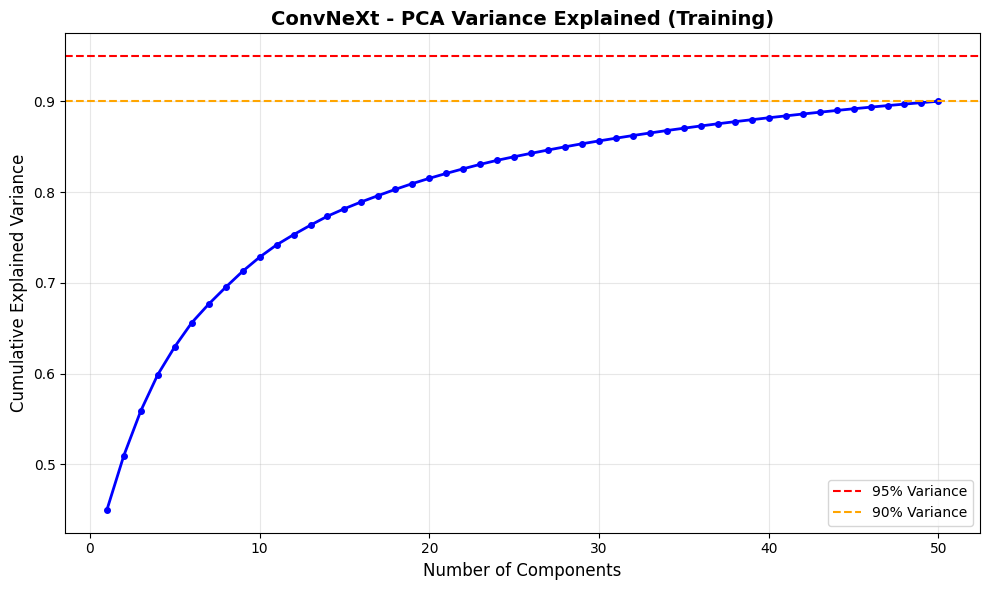


Applying t-SNE (perplexity=30, n_iter=1000)...
t-SNE completed.

Applying UMAP (n_neighbors=15, min_dist=0.1)...
UMAP completed.

Performing K-means clustering (k=2)...
Silhouette Score: 0.8288
Adjusted Rand Index: 0.0509
Normalized Mutual Information: 0.0400

Performing K-means clustering (k=2)...
Silhouette Score: 0.6458
Adjusted Rand Index: 0.0509
Normalized Mutual Information: 0.0400

Performing K-means clustering (k=2)...
Silhouette Score: 0.8539
Adjusted Rand Index: 0.0509
Normalized Mutual Information: 0.0400

Generating visualizations...
Saved: outputs/train/convnext/convnext_pca_visualization.png


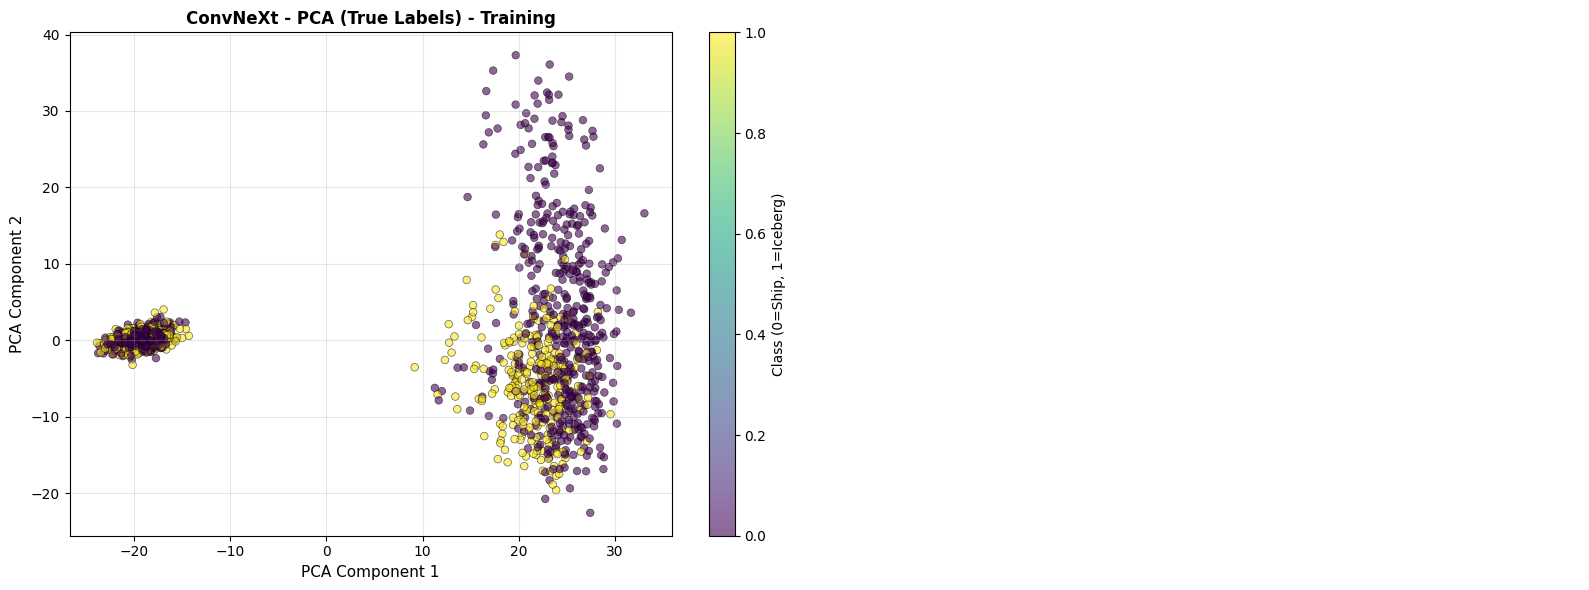

Saved: outputs/train/convnext/convnext_tsne_visualization.png


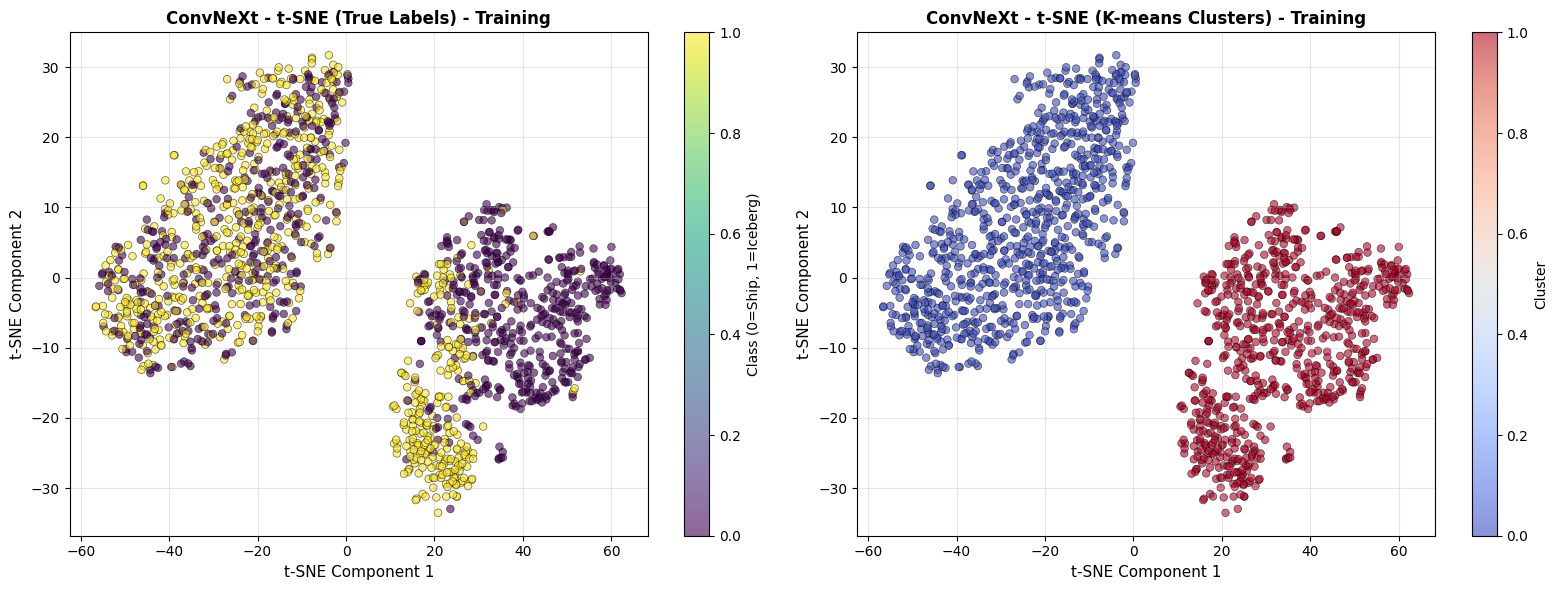

Saved: outputs/train/convnext/convnext_umap_visualization.png


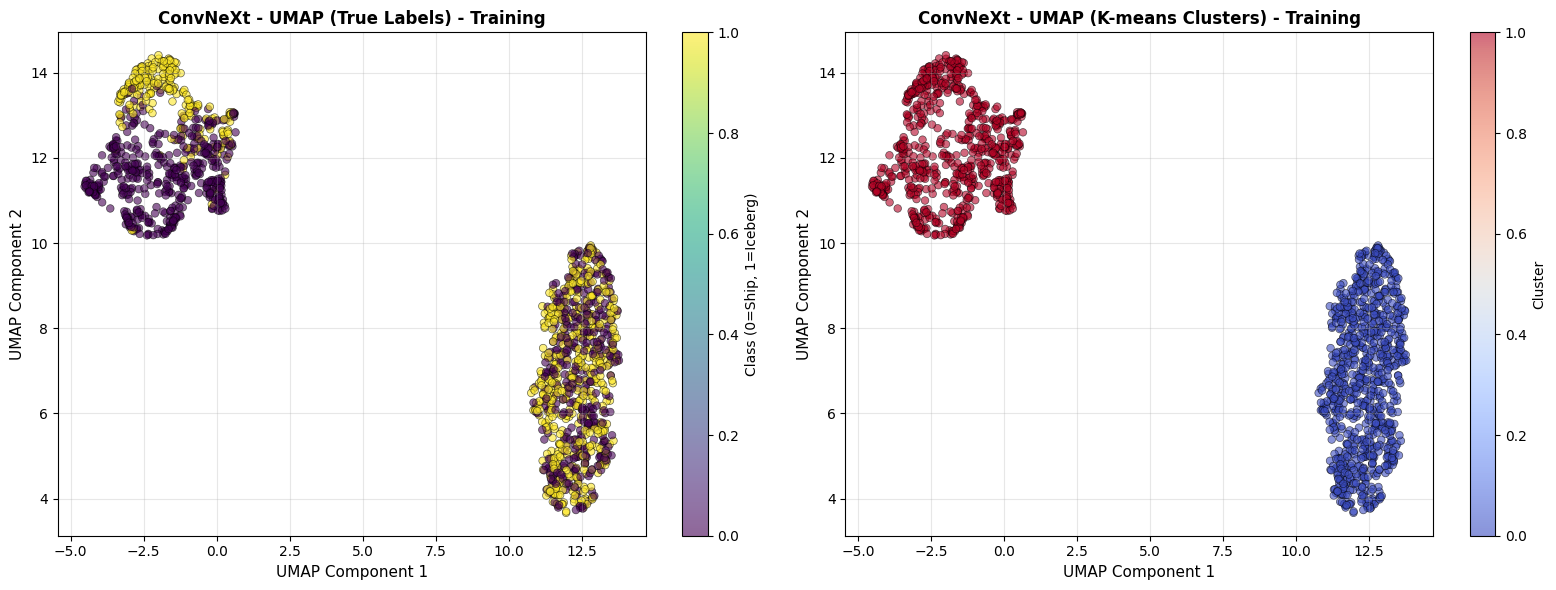

Saved: outputs/train/convnext/convnext_comparison.png


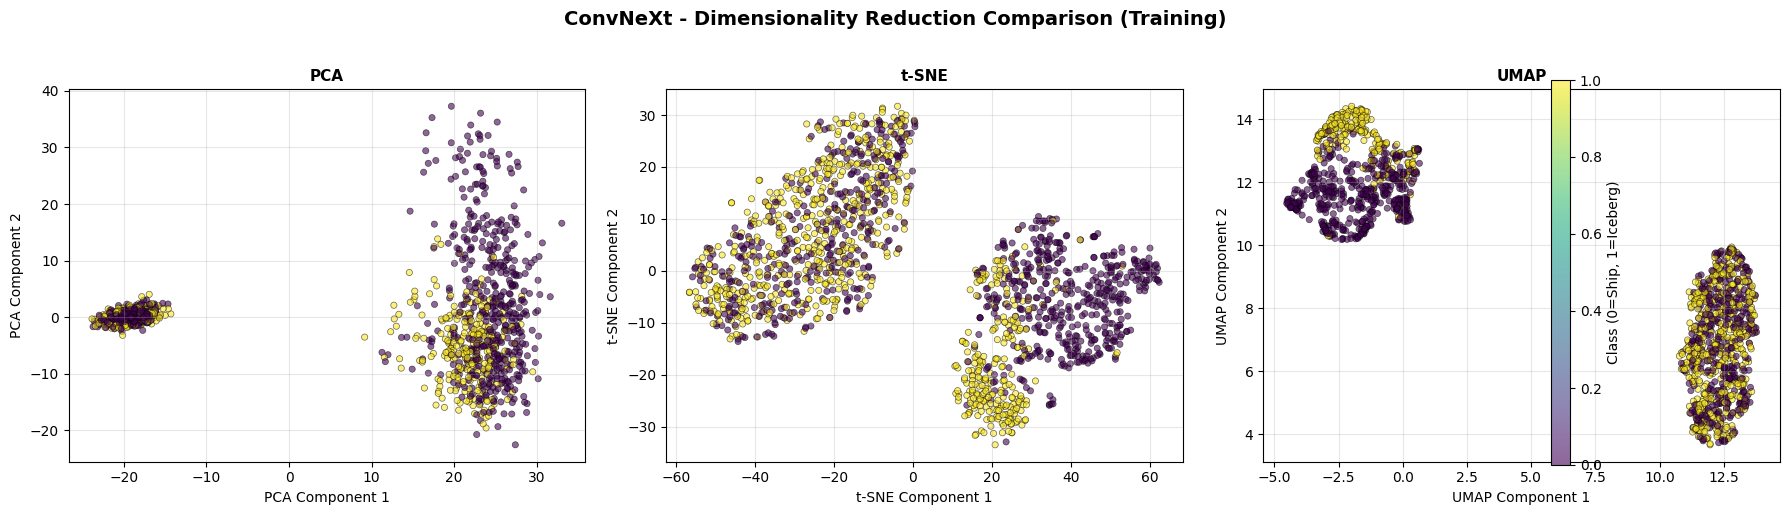


ConvNeXt EMBEDDINGS ANALYSIS SUMMARY - TRAINING DATA

Dataset Information:
  - Total samples: 1604
  - Embedding dimension: 1024
  - Class 0 (Ships): 851
  - Class 1 (Icebergs): 753

Dimensionality Reduction Results:

  PCA:
    - Silhouette Score: 0.8288
    - Adjusted Rand Index: 0.0509
    - Normalized Mutual Information: 0.0400

  t-SNE:
    - Silhouette Score: 0.6458
    - Adjusted Rand Index: 0.0509
    - Normalized Mutual Information: 0.0400

  UMAP:
    - Silhouette Score: 0.8539
    - Adjusted Rand Index: 0.0509
    - Normalized Mutual Information: 0.0400


Report saved to: outputs/train/convnext/convnext_analysis_report.txt

ANALYZING VIT EMBEDDINGS

Analyzing ViT Embeddings - TRAINING DATA
Embedding shape: (1604, 768)
Number of samples: 1604
Embedding dimension: 768
Class distribution: [851 753]
  - Class 0 (Ships): 851
  - Class 1 (Icebergs): 753

Applying PCA (n_components=50)...
Variance explained by 50 components: 0.8433
Variance explained by first 2 components: 0.4564


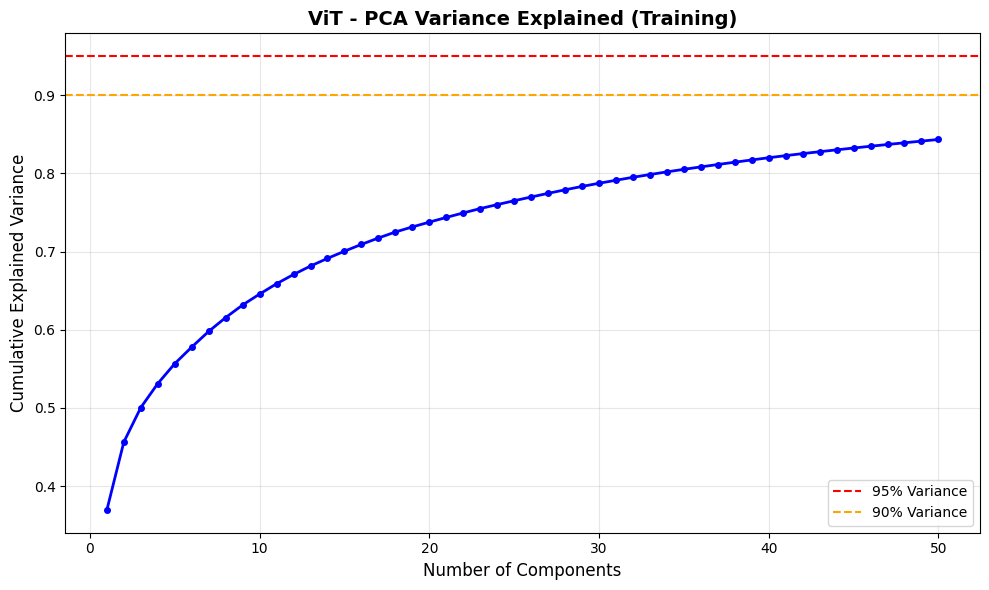


Applying t-SNE (perplexity=30, n_iter=1000)...
t-SNE completed.

Applying UMAP (n_neighbors=15, min_dist=0.1)...
UMAP completed.

Performing K-means clustering (k=2)...
Silhouette Score: 0.7718
Adjusted Rand Index: 0.0509
Normalized Mutual Information: 0.0400

Performing K-means clustering (k=2)...
Silhouette Score: 0.6629
Adjusted Rand Index: 0.0509
Normalized Mutual Information: 0.0400

Performing K-means clustering (k=2)...
Silhouette Score: 0.8867
Adjusted Rand Index: 0.0509
Normalized Mutual Information: 0.0400

Generating visualizations...
Saved: outputs/train/vit/vit_pca_visualization.png


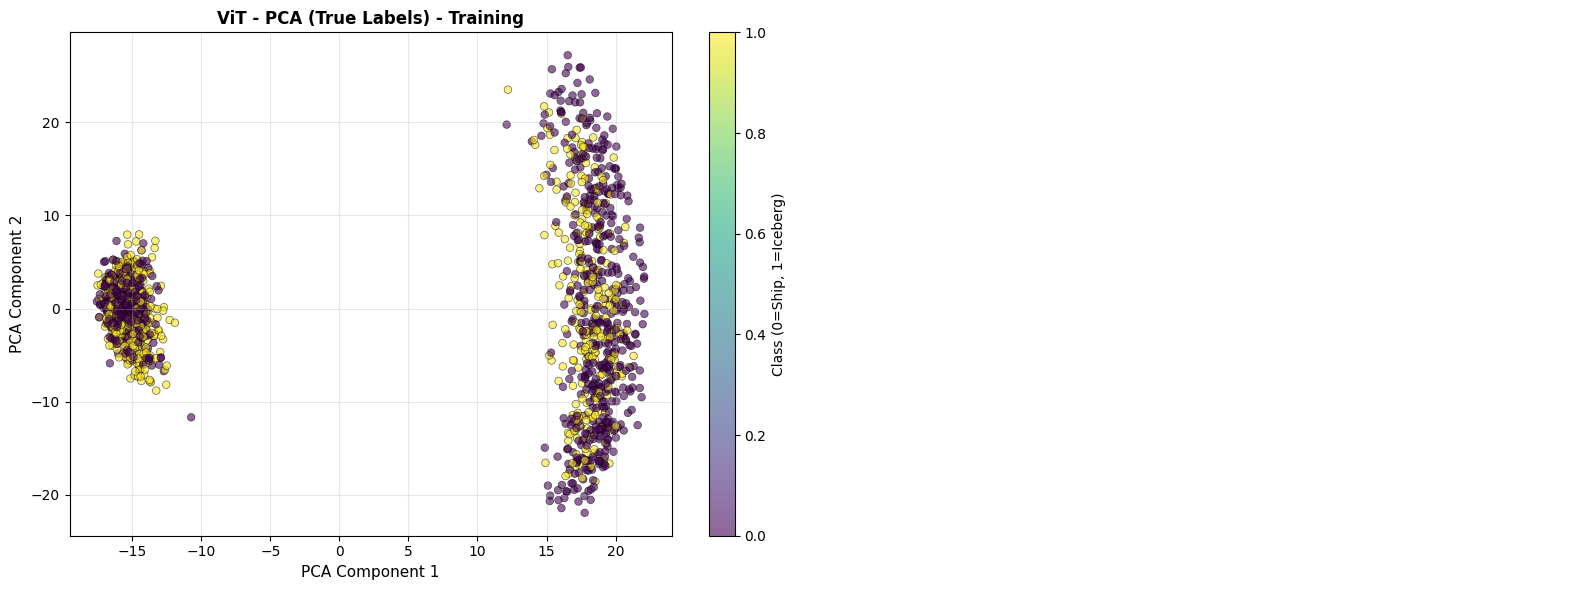

Saved: outputs/train/vit/vit_tsne_visualization.png


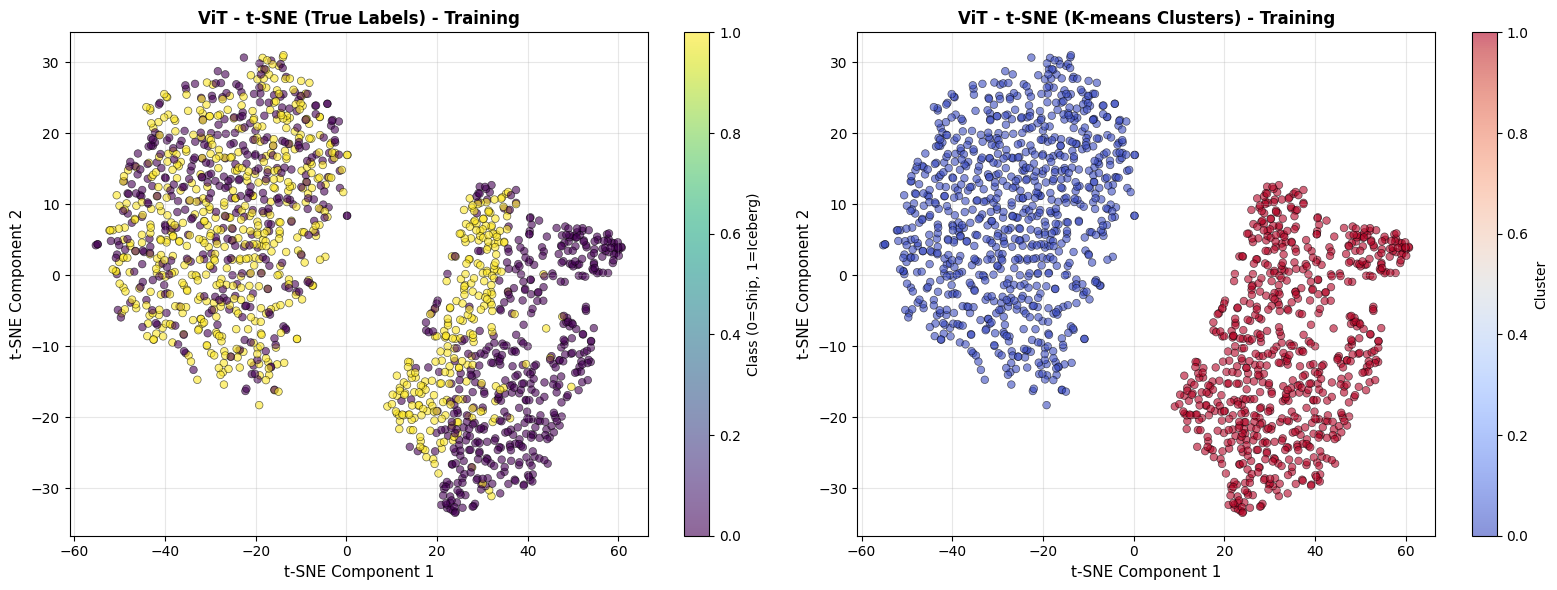

Saved: outputs/train/vit/vit_umap_visualization.png


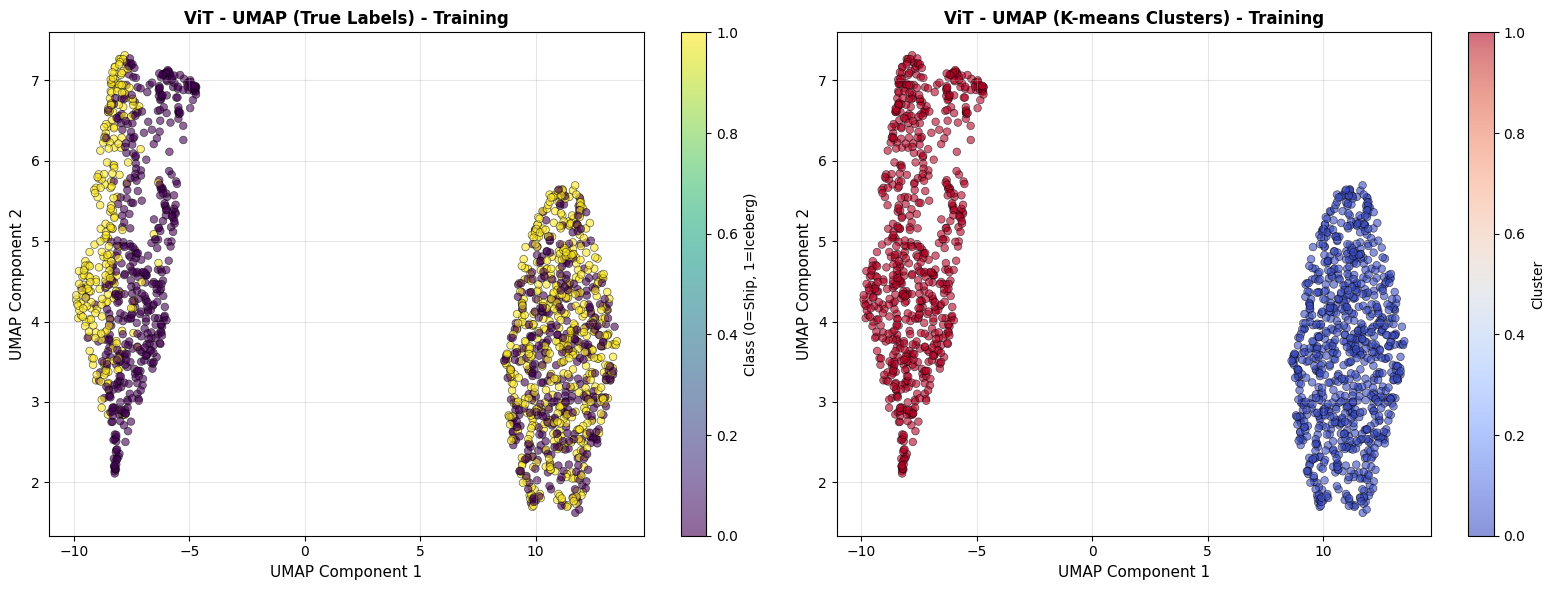

Saved: outputs/train/vit/vit_comparison.png


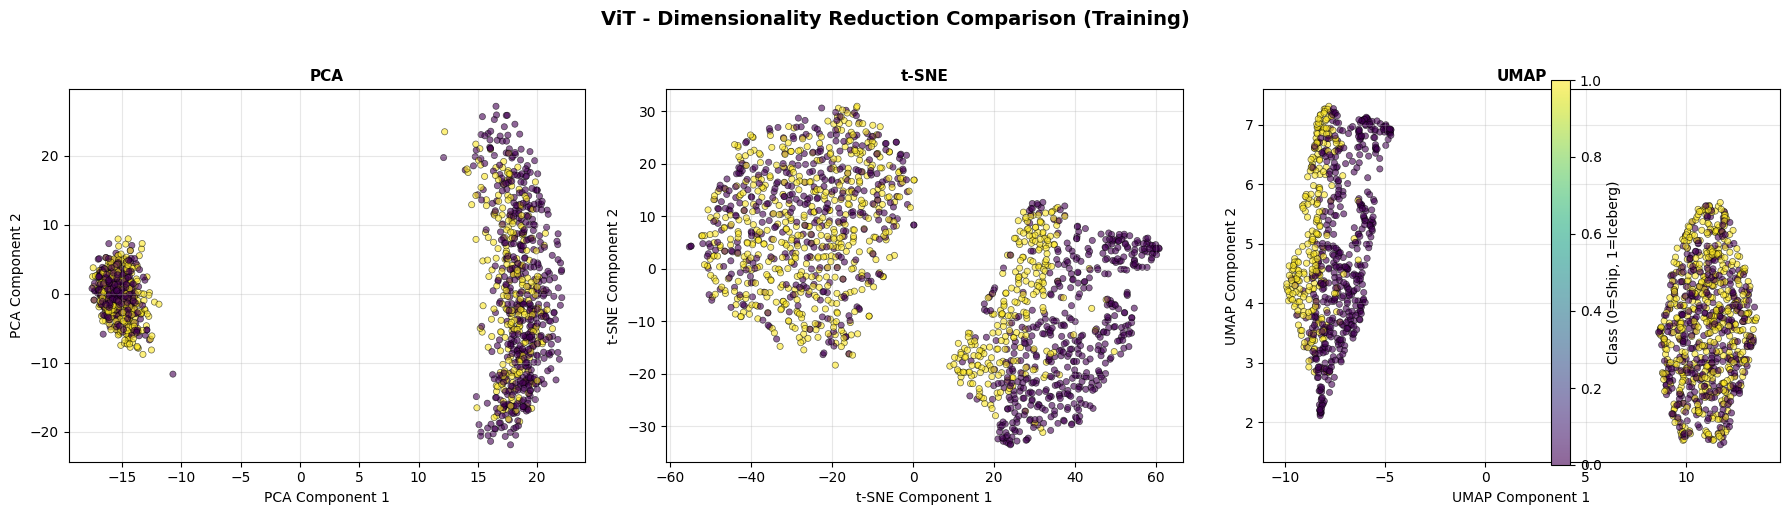


ViT EMBEDDINGS ANALYSIS SUMMARY - TRAINING DATA

Dataset Information:
  - Total samples: 1604
  - Embedding dimension: 768
  - Class 0 (Ships): 851
  - Class 1 (Icebergs): 753

Dimensionality Reduction Results:

  PCA:
    - Silhouette Score: 0.7718
    - Adjusted Rand Index: 0.0509
    - Normalized Mutual Information: 0.0400

  t-SNE:
    - Silhouette Score: 0.6629
    - Adjusted Rand Index: 0.0509
    - Normalized Mutual Information: 0.0400

  UMAP:
    - Silhouette Score: 0.8867
    - Adjusted Rand Index: 0.0509
    - Normalized Mutual Information: 0.0400


Report saved to: outputs/train/vit/vit_analysis_report.txt

COMPARISON SUMMARY - TRAINING DATA

ConvNeXt vs ViT Performance:

PCA:
  Silhouette Score:
    ConvNeXt: 0.8288
    ViT:      0.7718
    Winner:   ConvNeXt
  Adjusted Rand Index:
    ConvNeXt: 0.0509
    ViT:      0.0509
    Winner:   ViT
  Normalized Mutual Information:
    ConvNeXt: 0.0400
    ViT:      0.0400
    Winner:   ViT

t-SNE:
  Silhouette Score:
    ConvNeXt

In [ ]:
"""
Training Embeddings Analysis Script
Analyzes ConvNeXt and ViT embeddings from training data using dimensionality reduction
and clustering techniques to assess class separability.
"""

import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
import warnings
warnings.filterwarnings('ignore')

# Try to import UMAP, install if not available
try:
    from umap import UMAP
    UMAP_AVAILABLE = True
except ImportError:
    print("UMAP not available. Install with: pip install umap-learn")
    UMAP_AVAILABLE = False


class EmbeddingAnalyzer:
    """Analyzer for training embeddings with visualization and clustering."""

    def __init__(self, embeddings, labels, model_name):
        """
        Initialize the analyzer.

        Args:
            embeddings: numpy array of shape (n_samples, embedding_dim)
            labels: numpy array of shape (n_samples,) with class labels (0 or 1)
            model_name: str, name of the model (e.g., 'ConvNeXt', 'ViT')
        """
        self.embeddings = embeddings
        self.labels = labels
        self.model_name = model_name
        self.scaler = StandardScaler()

        # Normalize embeddings
        self.embeddings_normalized = self.scaler.fit_transform(self.embeddings)

        print(f"\n{'='*60}")
        print(f"Analyzing {model_name} Embeddings - TRAINING DATA")
        print(f"{'='*60}")
        print(f"Embedding shape: {self.embeddings.shape}")
        print(f"Number of samples: {len(self.labels)}")
        print(f"Embedding dimension: {self.embeddings.shape[1]}")
        print(f"Class distribution: {np.bincount(self.labels)}")
        print(f"  - Class 0 (Ships): {np.sum(self.labels == 0)}")
        print(f"  - Class 1 (Icebergs): {np.sum(self.labels == 1)}")

    def apply_pca(self, n_components=50):
        """Apply PCA for dimensionality reduction."""
        print(f"\nApplying PCA (n_components={n_components})...")
        pca = PCA(n_components=n_components)
        embeddings_pca = pca.fit_transform(self.embeddings_normalized)

        # Calculate variance explained
        cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
        print(f"Variance explained by {n_components} components: {cumulative_variance[-1]:.4f}")
        print(f"Variance explained by first 2 components: {cumulative_variance[1]:.4f}")

        return embeddings_pca, pca, cumulative_variance

    def apply_tsne(self, embeddings=None, perplexity=30, n_iter=1000):
        """Apply t-SNE for 2D visualization."""
        print(f"\nApplying t-SNE (perplexity={perplexity}, n_iter={n_iter})...")
        if embeddings is None:
            embeddings = self.embeddings_normalized

        tsne = TSNE(n_components=2, perplexity=perplexity, n_iter=n_iter,
                    random_state=42, verbose=0)
        embeddings_tsne = tsne.fit_transform(embeddings)
        print("t-SNE completed.")

        return embeddings_tsne

    def apply_umap(self, embeddings=None, n_neighbors=15, min_dist=0.1):
        """Apply UMAP for 2D visualization."""
        if not UMAP_AVAILABLE:
            print("UMAP not available, skipping...")
            return None

        print(f"\nApplying UMAP (n_neighbors={n_neighbors}, min_dist={min_dist})...")
        if embeddings is None:
            embeddings = self.embeddings_normalized

        umap_model = UMAP(n_components=2, n_neighbors=n_neighbors,
                         min_dist=min_dist, random_state=42)
        embeddings_umap = umap_model.fit_transform(embeddings)
        print("UMAP completed.")

        return embeddings_umap

    def perform_clustering(self, embeddings, n_clusters=2):
        """Perform K-means clustering and evaluate."""
        print(f"\nPerforming K-means clustering (k={n_clusters})...")
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(embeddings)

        # Calculate metrics
        silhouette = silhouette_score(embeddings, cluster_labels)
        ari = adjusted_rand_score(self.labels, cluster_labels)
        nmi = normalized_mutual_info_score(self.labels, cluster_labels)

        print(f"Silhouette Score: {silhouette:.4f}")
        print(f"Adjusted Rand Index: {ari:.4f}")
        print(f"Normalized Mutual Information: {nmi:.4f}")

        return cluster_labels, silhouette, ari, nmi

    def plot_variance_explained(self, cumulative_variance, save_path=None):
        """Plot cumulative variance explained by PCA components."""
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance,
                'bo-', linewidth=2, markersize=4)
        plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance')
        plt.axhline(y=0.90, color='orange', linestyle='--', label='90% Variance')
        plt.xlabel('Number of Components', fontsize=12)
        plt.ylabel('Cumulative Explained Variance', fontsize=12)
        plt.title(f'{self.model_name} - PCA Variance Explained (Training)', fontsize=14, fontweight='bold')
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Saved: {save_path}")
        plt.show()

    def plot_2d_embeddings(self, embeddings, method_name, cluster_labels=None, save_path=None):
        """Plot 2D embeddings with class labels and optional cluster boundaries."""
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))

        # Plot 1: True labels
        scatter1 = axes[0].scatter(embeddings[:, 0], embeddings[:, 1],
                                   c=self.labels, cmap='viridis',
                                   alpha=0.6, s=30, edgecolors='k', linewidth=0.5)
        axes[0].set_xlabel(f'{method_name} Component 1', fontsize=11)
        axes[0].set_ylabel(f'{method_name} Component 2', fontsize=11)
        axes[0].set_title(f'{self.model_name} - {method_name} (True Labels) - Training',
                         fontsize=12, fontweight='bold')
        cbar1 = plt.colorbar(scatter1, ax=axes[0])
        cbar1.set_label('Class (0=Ship, 1=Iceberg)', fontsize=10)
        axes[0].grid(True, alpha=0.3)

        # Plot 2: Cluster labels (if provided)
        if cluster_labels is not None:
            scatter2 = axes[1].scatter(embeddings[:, 0], embeddings[:, 1],
                                      c=cluster_labels, cmap='coolwarm',
                                      alpha=0.6, s=30, edgecolors='k', linewidth=0.5)
            axes[1].set_xlabel(f'{method_name} Component 1', fontsize=11)
            axes[1].set_ylabel(f'{method_name} Component 2', fontsize=11)
            axes[1].set_title(f'{self.model_name} - {method_name} (K-means Clusters) - Training',
                            fontsize=12, fontweight='bold')
            cbar2 = plt.colorbar(scatter2, ax=axes[1])
            cbar2.set_label('Cluster', fontsize=10)
            axes[1].grid(True, alpha=0.3)
        else:
            axes[1].axis('off')

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Saved: {save_path}")
        plt.show()

    def create_comparison_plot(self, pca_2d, tsne_2d, umap_2d=None, save_path=None):
        """Create a comparison plot of all dimensionality reduction methods."""
        n_methods = 3 if umap_2d is not None else 2
        fig, axes = plt.subplots(1, n_methods, figsize=(6*n_methods, 5))

        if n_methods == 2:
            axes = [axes[0], axes[1]]

        methods = [
            (pca_2d, 'PCA', axes[0]),
            (tsne_2d, 't-SNE', axes[1])
        ]

        if umap_2d is not None:
            methods.append((umap_2d, 'UMAP', axes[2]))

        for embeddings, name, ax in methods:
            scatter = ax.scatter(embeddings[:, 0], embeddings[:, 1],
                               c=self.labels, cmap='viridis',
                               alpha=0.6, s=20, edgecolors='k', linewidth=0.5)
            ax.set_xlabel(f'{name} Component 1', fontsize=10)
            ax.set_ylabel(f'{name} Component 2', fontsize=10)
            ax.set_title(f'{name}', fontsize=11, fontweight='bold')
            ax.grid(True, alpha=0.3)

        # Add a shared colorbar
        fig.colorbar(scatter, ax=axes, label='Class (0=Ship, 1=Iceberg)',
                    fraction=0.046, pad=0.04)

        fig.suptitle(f'{self.model_name} - Dimensionality Reduction Comparison (Training)',
                    fontsize=14, fontweight='bold', y=1.02)
        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Saved: {save_path}")
        plt.show()

    def generate_summary_report(self, metrics_dict, save_path=None):
        """Generate a text summary report of all metrics."""
        report = f"\n{'='*70}\n"
        report += f"{self.model_name} EMBEDDINGS ANALYSIS SUMMARY - TRAINING DATA\n"
        report += f"{'='*70}\n\n"

        report += f"Dataset Information:\n"
        report += f"  - Total samples: {len(self.labels)}\n"
        report += f"  - Embedding dimension: {self.embeddings.shape[1]}\n"
        report += f"  - Class 0 (Ships): {np.sum(self.labels == 0)}\n"
        report += f"  - Class 1 (Icebergs): {np.sum(self.labels == 1)}\n\n"

        report += f"Dimensionality Reduction Results:\n"
        for method, metrics in metrics_dict.items():
            report += f"\n  {method}:\n"
            for metric_name, value in metrics.items():
                report += f"    - {metric_name}: {value:.4f}\n"

        report += f"\n{'='*70}\n"

        print(report)

        if save_path:
            with open(save_path, 'w') as f:
                f.write(report)
            print(f"Report saved to: {save_path}")

        return report


def load_embeddings(convnext_path, vit_path, labels_path):
    """
    Load embeddings and labels from pickle files.

    Args:
        convnext_path: path to ConvNeXt embeddings .pkl file
        vit_path: path to ViT embeddings .pkl file
        labels_path: path to labels .pkl file

    Returns:
        convnext_embeddings, vit_embeddings, labels (all as numpy arrays)
    """
    print("Loading embeddings and labels...")

    with open(convnext_path, 'rb') as f:
        convnext_embeddings = pickle.load(f)

    with open(vit_path, 'rb') as f:
        vit_embeddings = pickle.load(f)

    with open(labels_path, 'rb') as f:
        labels = pickle.load(f)

    # Ensure they are numpy arrays
    convnext_embeddings = np.array(convnext_embeddings)
    vit_embeddings = np.array(vit_embeddings)
    labels = np.array(labels)

    print(f"Loaded ConvNeXt embeddings: {convnext_embeddings.shape}")
    print(f"Loaded ViT embeddings: {vit_embeddings.shape}")
    print(f"Loaded labels: {labels.shape}")

    return convnext_embeddings, vit_embeddings, labels


def analyze_model_embeddings(embeddings, labels, model_name, output_dir='outputs/train'):
    """
    Complete analysis pipeline for one model's embeddings.

    Args:
        embeddings: numpy array of embeddings
        labels: numpy array of labels
        model_name: name of the model
        output_dir: directory to save outputs
    """
    import os
    os.makedirs(output_dir, exist_ok=True)

    # Initialize analyzer
    analyzer = EmbeddingAnalyzer(embeddings, labels, model_name)

    # Apply PCA
    embeddings_pca, pca, cumulative_variance = analyzer.apply_pca(n_components=50)
    analyzer.plot_variance_explained(
        cumulative_variance,
        save_path=f'{output_dir}/{model_name.lower()}_pca_variance.png'
    )

    # Get 2D PCA for visualization
    pca_2d = embeddings_pca[:, :2]

    # Apply t-SNE on PCA-reduced embeddings (faster and often better)
    tsne_2d = analyzer.apply_tsne(embeddings_pca, perplexity=30, n_iter=1000)

    # Apply UMAP if available
    umap_2d = analyzer.apply_umap(embeddings_pca, n_neighbors=15, min_dist=0.1)

    # Clustering analysis
    metrics_dict = {}

    # PCA clustering
    _, sil_pca, ari_pca, nmi_pca = analyzer.perform_clustering(pca_2d)
    metrics_dict['PCA'] = {
        'Silhouette Score': sil_pca,
        'Adjusted Rand Index': ari_pca,
        'Normalized Mutual Information': nmi_pca
    }

    # t-SNE clustering
    cluster_labels_tsne, sil_tsne, ari_tsne, nmi_tsne = analyzer.perform_clustering(tsne_2d)
    metrics_dict['t-SNE'] = {
        'Silhouette Score': sil_tsne,
        'Adjusted Rand Index': ari_tsne,
        'Normalized Mutual Information': nmi_tsne
    }

    # UMAP clustering
    if umap_2d is not None:
        cluster_labels_umap, sil_umap, ari_umap, nmi_umap = analyzer.perform_clustering(umap_2d)
        metrics_dict['UMAP'] = {
            'Silhouette Score': sil_umap,
            'Adjusted Rand Index': ari_umap,
            'Normalized Mutual Information': nmi_umap
        }

    # Visualization
    print("\nGenerating visualizations...")

    # PCA plot
    analyzer.plot_2d_embeddings(
        pca_2d, 'PCA',
        save_path=f'{output_dir}/{model_name.lower()}_pca_visualization.png'
    )

    # t-SNE plot
    analyzer.plot_2d_embeddings(
        tsne_2d, 't-SNE', cluster_labels_tsne,
        save_path=f'{output_dir}/{model_name.lower()}_tsne_visualization.png'
    )

    # UMAP plot
    if umap_2d is not None:
        analyzer.plot_2d_embeddings(
            umap_2d, 'UMAP', cluster_labels_umap,
            save_path=f'{output_dir}/{model_name.lower()}_umap_visualization.png'
        )

    # Comparison plot
    analyzer.create_comparison_plot(
        pca_2d, tsne_2d, umap_2d,
        save_path=f'{output_dir}/{model_name.lower()}_comparison.png'
    )

    # Generate report
    analyzer.generate_summary_report(
        metrics_dict,
        save_path=f'{output_dir}/{model_name.lower()}_analysis_report.txt'
    )

    return metrics_dict


def main():
    """Main execution function."""
    # =================================================================
    # CONFIGURATION - UPDATE THESE PATHS
    # =================================================================
    CONVNEXT_TRAIN_PATH = '/content/convnext_train_embeddings.pkl'
    VIT_TRAIN_PATH = '/content/vit_train_embeddings.pkl'
    TRAIN_LABELS_PATH = '/content/train_labels.pkl'
    OUTPUT_DIR = 'outputs/train'

    # =================================================================

    print("\n" + "="*70)
    print("TRAINING EMBEDDINGS ANALYSIS")
    print("="*70)

    # Load embeddings
    convnext_embeddings, vit_embeddings, labels = load_embeddings(
        CONVNEXT_TRAIN_PATH, VIT_TRAIN_PATH, TRAIN_LABELS_PATH
    )

    # Analyze ConvNeXt embeddings
    print("\n" + "="*70)
    print("ANALYZING CONVNEXT EMBEDDINGS")
    print("="*70)
    convnext_metrics = analyze_model_embeddings(
        convnext_embeddings, labels, 'ConvNeXt',
        output_dir=f'{OUTPUT_DIR}/convnext'
    )

    # Analyze ViT embeddings
    print("\n" + "="*70)
    print("ANALYZING VIT EMBEDDINGS")
    print("="*70)
    vit_metrics = analyze_model_embeddings(
        vit_embeddings, labels, 'ViT',
        output_dir=f'{OUTPUT_DIR}/vit'
    )

    # Final comparison
    print("\n" + "="*70)
    print("COMPARISON SUMMARY - TRAINING DATA")
    print("="*70)
    print("\nConvNeXt vs ViT Performance:")
    for method in convnext_metrics.keys():
        print(f"\n{method}:")
        for metric in convnext_metrics[method].keys():
            conv_val = convnext_metrics[method][metric]
            vit_val = vit_metrics[method][metric]
            better = "ConvNeXt" if conv_val > vit_val else "ViT"
            print(f"  {metric}:")
            print(f"    ConvNeXt: {conv_val:.4f}")
            print(f"    ViT:      {vit_val:.4f}")
            print(f"    Winner:   {better}")

    print("\n" + "="*70)
    print("ANALYSIS COMPLETE!")
    print(f"All outputs saved to: {OUTPUT_DIR}")
    print("="*70)


if __name__ == "__main__":
    main()


TEST EMBEDDINGS ANALYSIS - UNSUPERVISED MODE
(No labels required)
Loading test embeddings (no labels)...
Loaded ConvNeXt test embeddings: (8424, 1024)
Loaded ViT test embeddings: (8424, 768)

ANALYZING CONVNEXT TEST EMBEDDINGS

Analyzing ConvNeXt Embeddings - TEST DATA (Unsupervised)
Embedding shape: (8424, 1024)
Number of samples: 8424
Embedding dimension: 1024

Applying PCA (n_components=50)...
Variance explained by 50 components: 0.8317
Variance explained by first 2 components: 0.3676
Saved: outputs/test_unsupervised/convnext/convnext_pca_variance.png


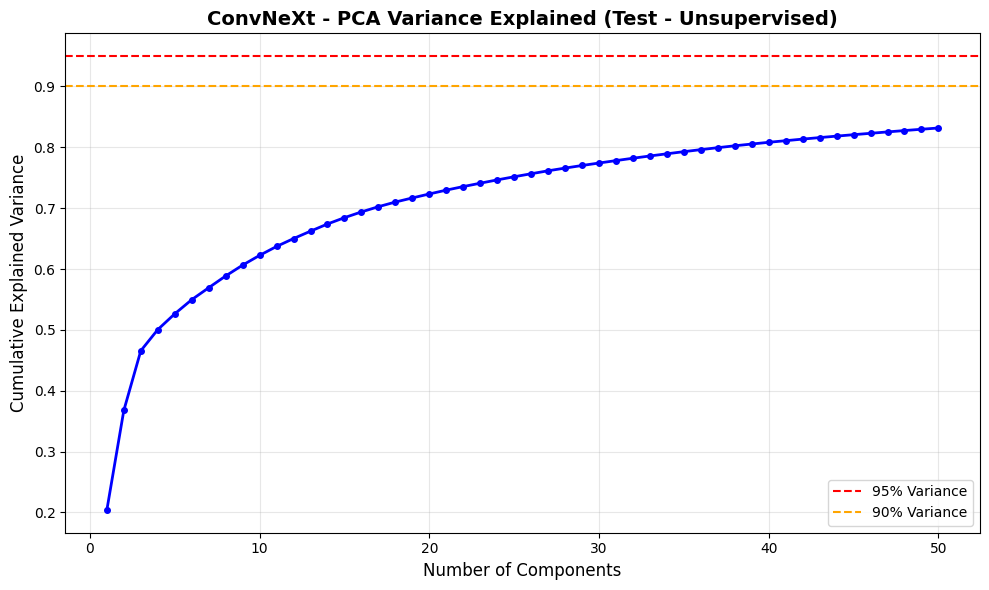


Finding optimal number of clusters...
Optimal k based on silhouette score: 4
Saved: outputs/test_unsupervised/convnext/convnext_elbow_analysis.png


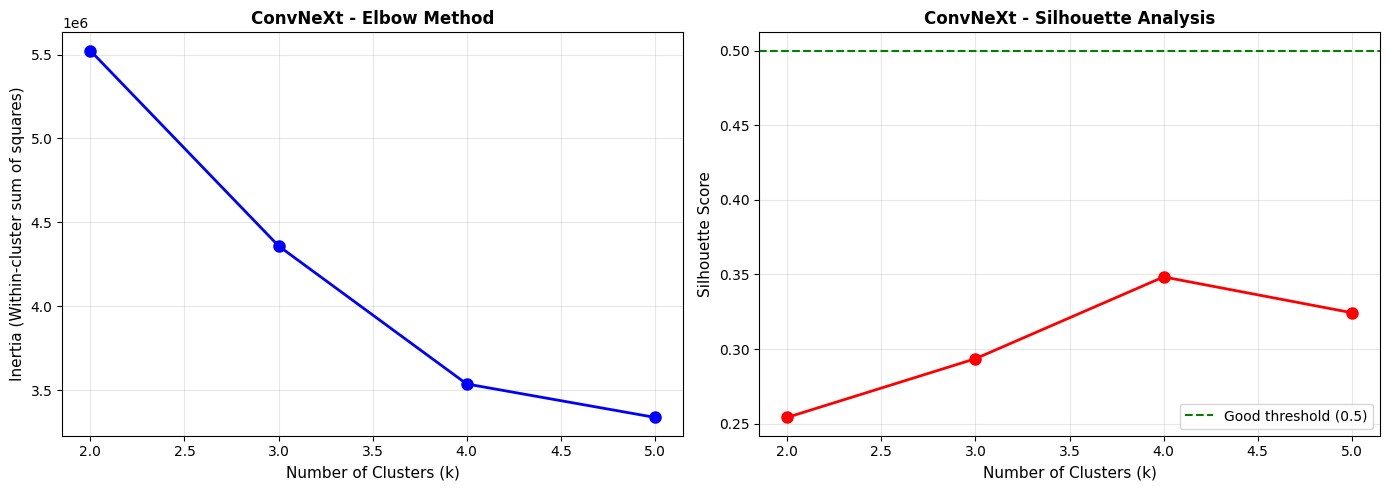


Applying t-SNE (perplexity=30, n_iter=1000)...
t-SNE completed.

Applying UMAP (n_neighbors=15, min_dist=0.1)...
UMAP completed.

Performing K-means clustering (k=2)...
Silhouette Score: 0.5438 (higher is better)
Davies-Bouldin Index: 0.8366 (lower is better)
Calinski-Harabasz Score: 9045.87 (higher is better)

Cluster Size Distribution:
  Cluster 0: 3802 samples (45.1%)
  Cluster 1: 4622 samples (54.9%)

Cluster Balance Ratio: 0.823
  (1.0 = perfect balance, closer to 1.0 is better)

Performing K-means clustering (k=2)...
Silhouette Score: 0.4138 (higher is better)
Davies-Bouldin Index: 1.0556 (lower is better)
Calinski-Harabasz Score: 6327.55 (higher is better)

Cluster Size Distribution:
  Cluster 0: 4918 samples (58.4%)
  Cluster 1: 3506 samples (41.6%)

Cluster Balance Ratio: 0.713
  (1.0 = perfect balance, closer to 1.0 is better)

Performing K-means clustering (k=2)...
Silhouette Score: 0.5839 (higher is better)
Davies-Bouldin Index: 0.8516 (lower is better)
Calinski-Harabasz S

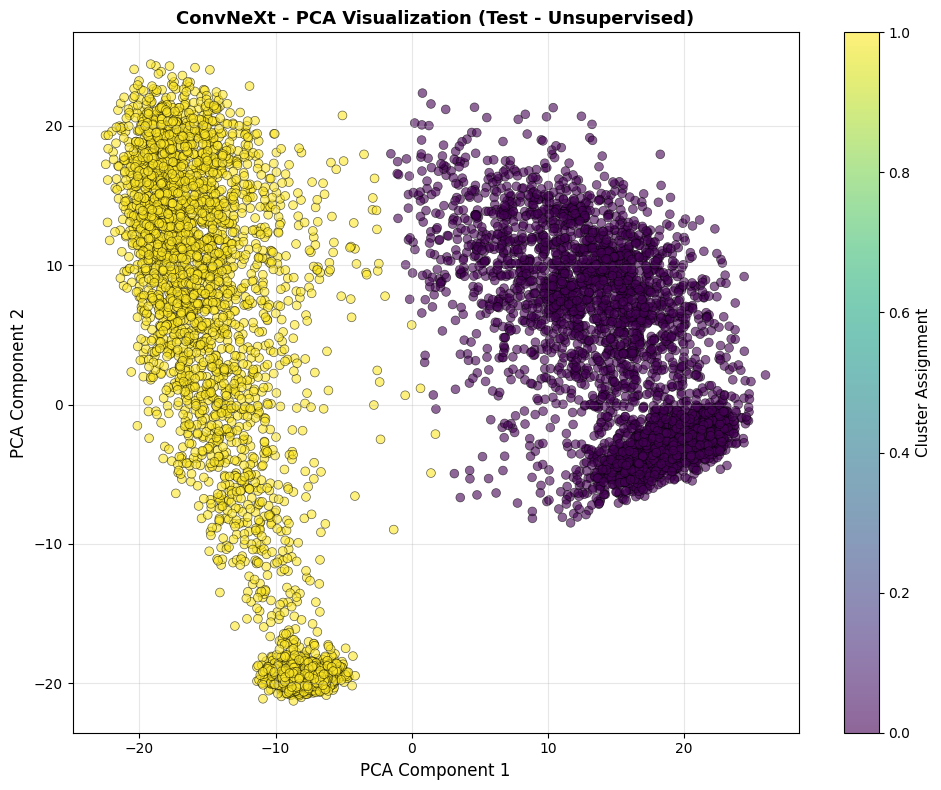

Saved: outputs/test_unsupervised/convnext/convnext_tsne_visualization.png


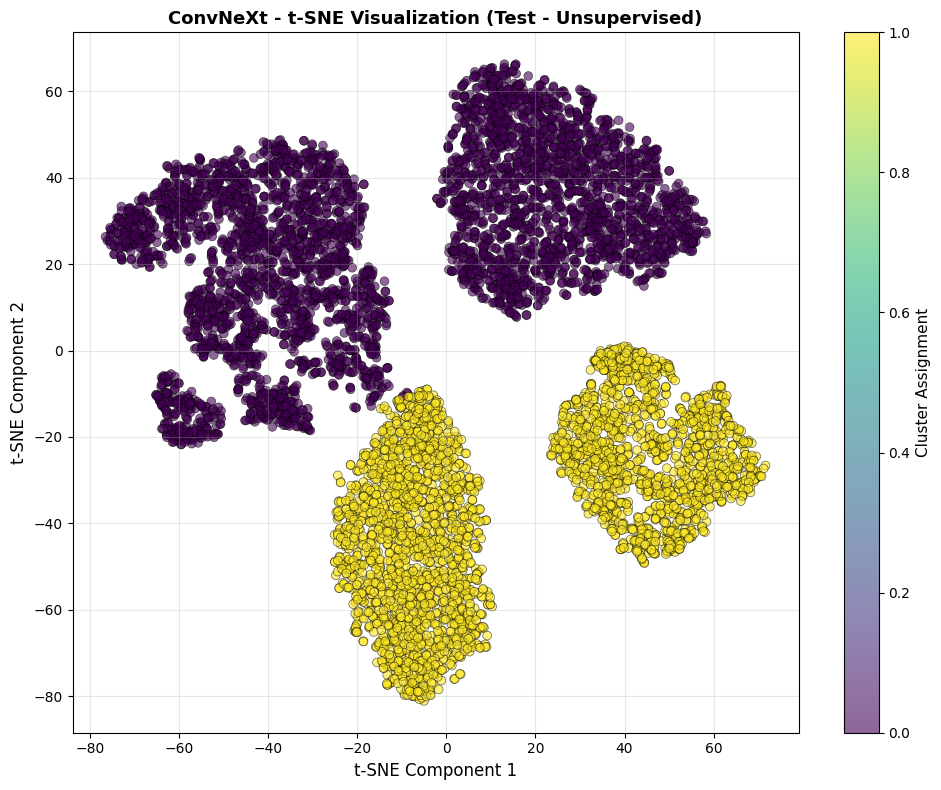

Saved: outputs/test_unsupervised/convnext/convnext_umap_visualization.png


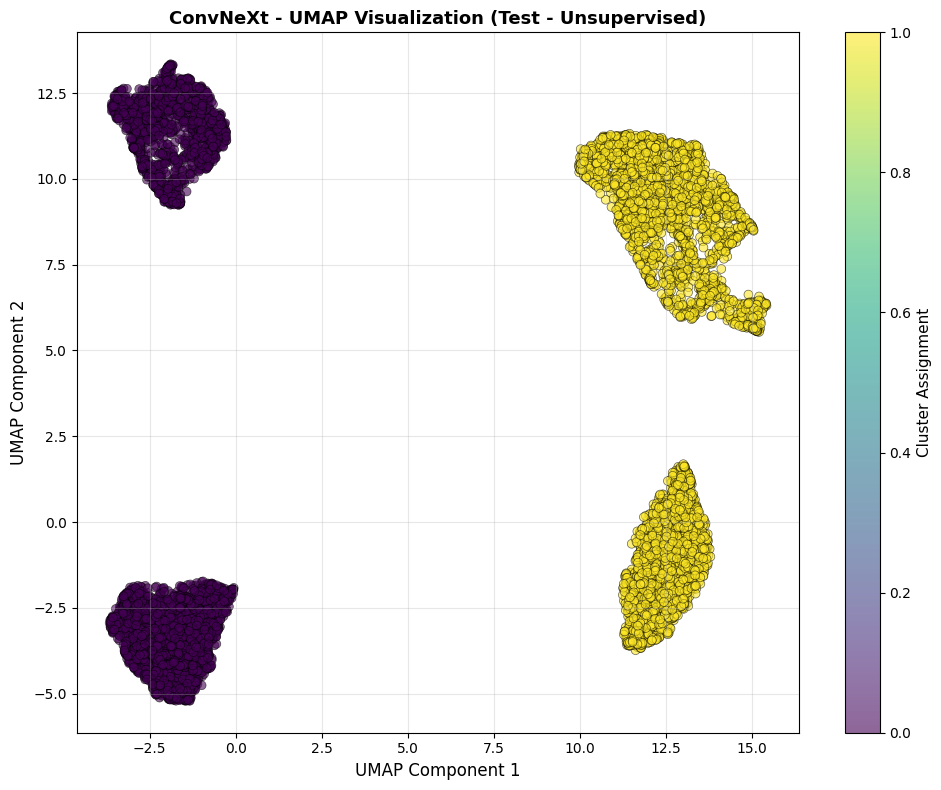

Saved: outputs/test_unsupervised/convnext/convnext_comparison.png


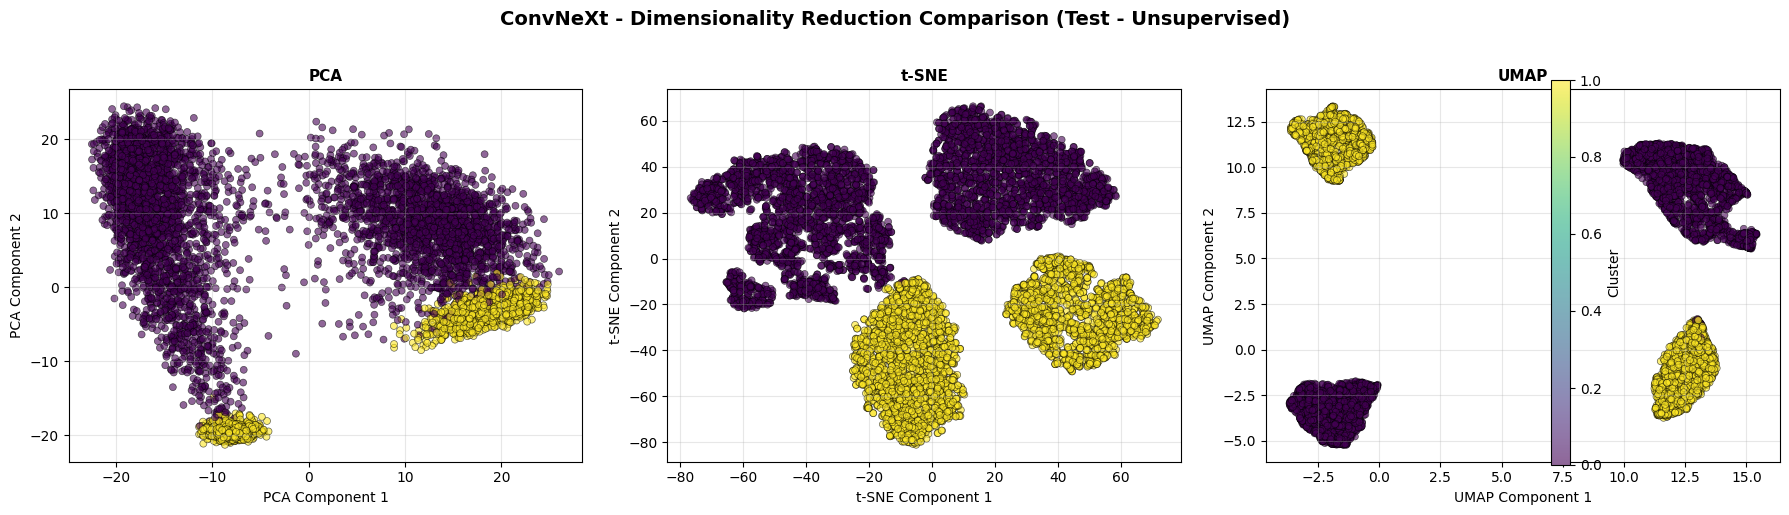


ConvNeXt EMBEDDINGS ANALYSIS - TEST DATA (UNSUPERVISED)

Dataset Information:
  - Total samples: 8424
  - Embedding dimension: 1024

Unsupervised Clustering Results:
Note: These metrics don't require true labels

  PCA:
    - Silhouette Score: 0.5438
    - Davies-Bouldin Index: 0.8366 (lower is better)
    - Calinski-Harabasz Score: 9045.87 (higher is better)
    - Cluster Balance: 0.823

  t-SNE:
    - Silhouette Score: 0.4138
    - Davies-Bouldin Index: 1.0556 (lower is better)
    - Calinski-Harabasz Score: 6327.55 (higher is better)
    - Cluster Balance: 0.713

  UMAP:
    - Silhouette Score: 0.5839
    - Davies-Bouldin Index: 0.8516 (lower is better)
    - Calinski-Harabasz Score: 10860.05 (higher is better)
    - Cluster Balance: 0.833

INTERPRETATION GUIDE:
  - Silhouette Score > 0.5: Well-defined clusters
  - Davies-Bouldin < 1.0: Good cluster separation
  - Balance Ratio > 0.7: Balanced cluster sizes

Report saved to: outputs/test_unsupervised/convnext/convnext_analysis_repo

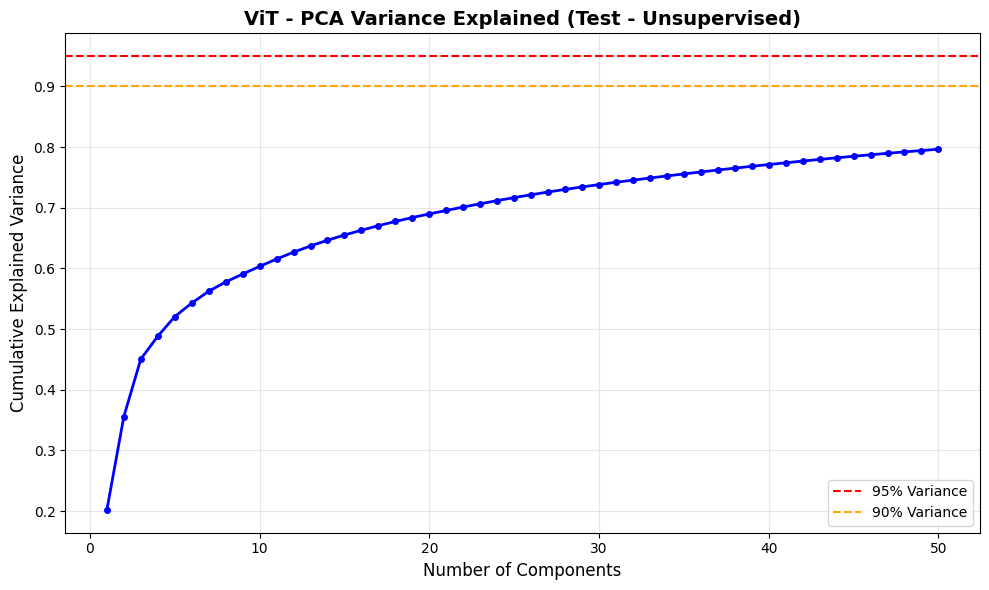


Finding optimal number of clusters...
Optimal k based on silhouette score: 4
Saved: outputs/test_unsupervised/vit/vit_elbow_analysis.png


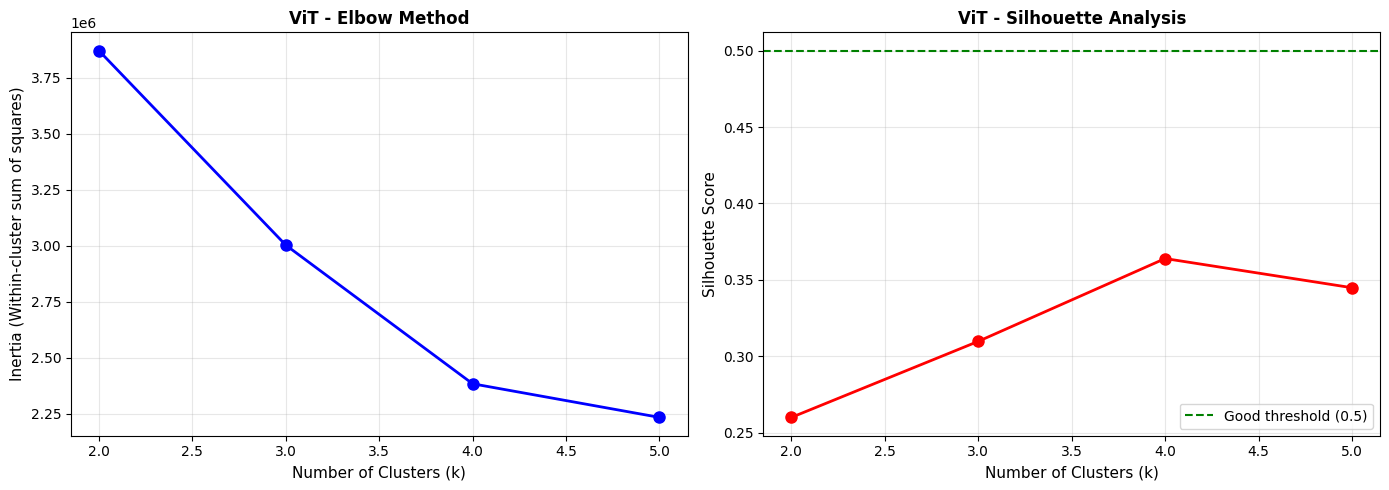


Applying t-SNE (perplexity=30, n_iter=1000)...
t-SNE completed.

Applying UMAP (n_neighbors=15, min_dist=0.1)...
UMAP completed.

Performing K-means clustering (k=2)...
Silhouette Score: 0.5861 (higher is better)
Davies-Bouldin Index: 0.7814 (lower is better)
Calinski-Harabasz Score: 10570.42 (higher is better)

Cluster Size Distribution:
  Cluster 0: 3829 samples (45.5%)
  Cluster 1: 4595 samples (54.5%)

Cluster Balance Ratio: 0.833
  (1.0 = perfect balance, closer to 1.0 is better)

Performing K-means clustering (k=2)...
Silhouette Score: 0.4200 (higher is better)
Davies-Bouldin Index: 1.0641 (lower is better)
Calinski-Harabasz Score: 6476.08 (higher is better)

Cluster Size Distribution:
  Cluster 0: 4591 samples (54.5%)
  Cluster 1: 3833 samples (45.5%)

Cluster Balance Ratio: 0.835
  (1.0 = perfect balance, closer to 1.0 is better)

Performing K-means clustering (k=2)...
Silhouette Score: 0.6493 (higher is better)
Davies-Bouldin Index: 0.5783 (lower is better)
Calinski-Harabasz 

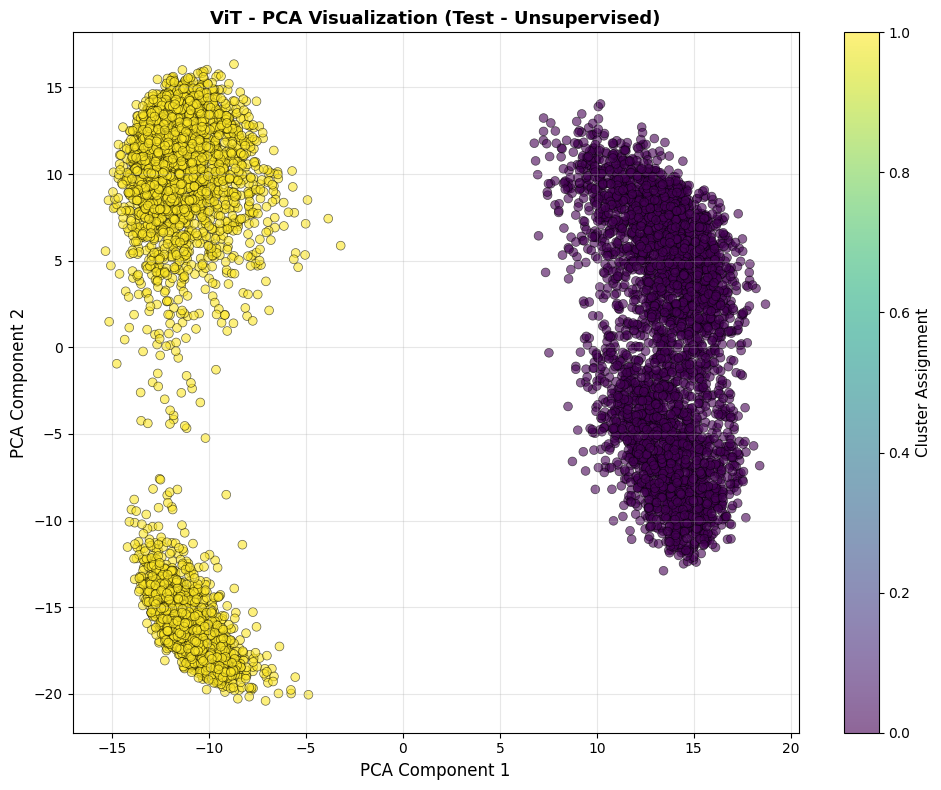

Saved: outputs/test_unsupervised/vit/vit_tsne_visualization.png


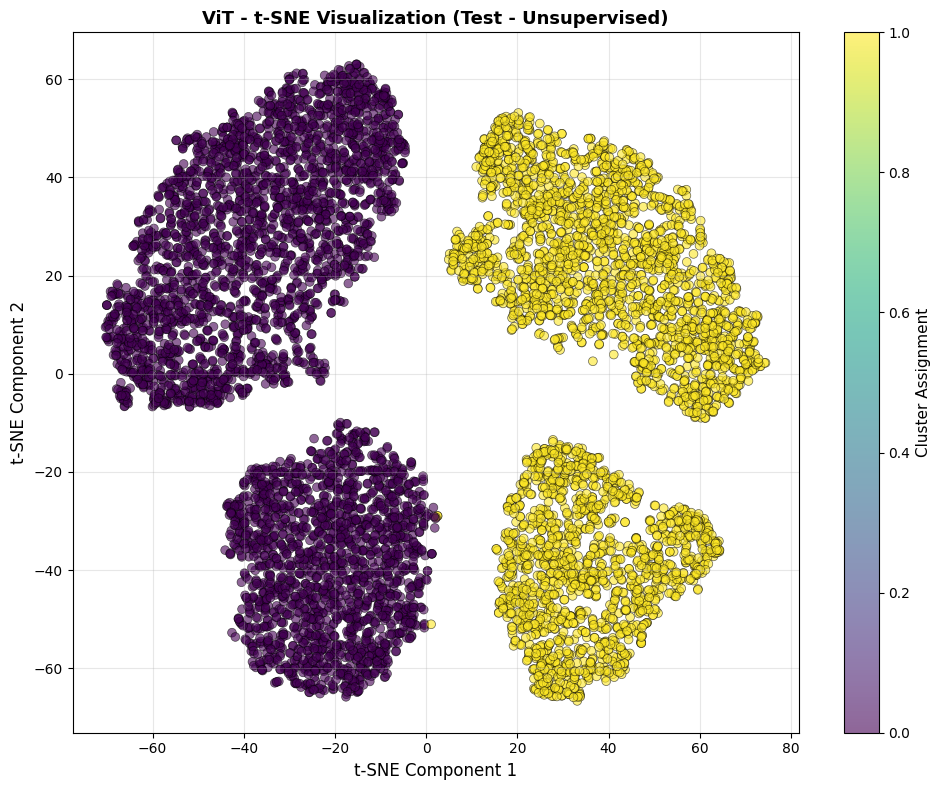

Saved: outputs/test_unsupervised/vit/vit_umap_visualization.png


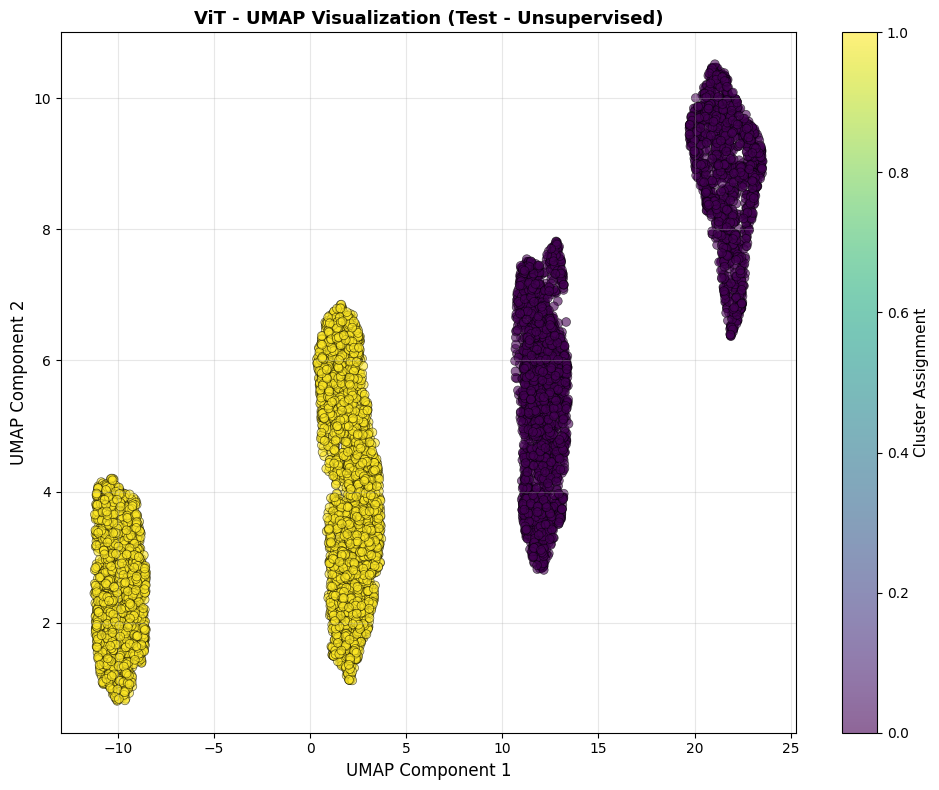

Saved: outputs/test_unsupervised/vit/vit_comparison.png


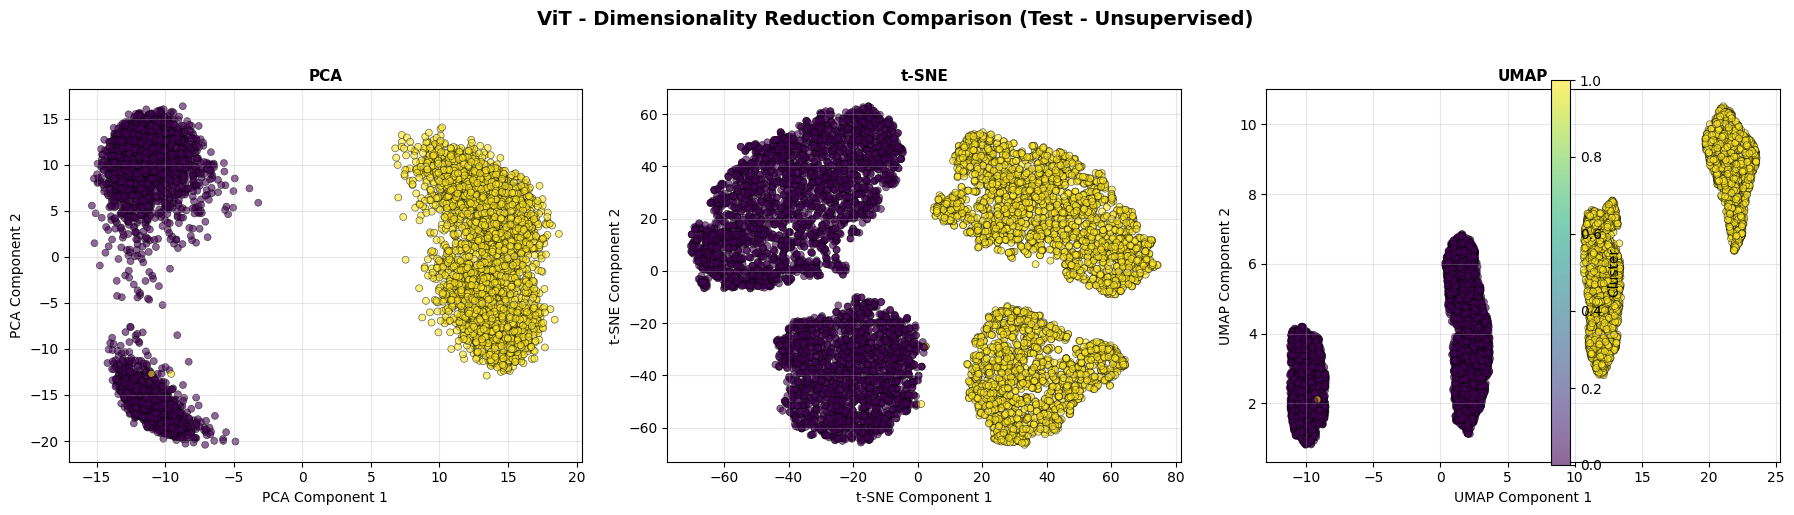


ViT EMBEDDINGS ANALYSIS - TEST DATA (UNSUPERVISED)

Dataset Information:
  - Total samples: 8424
  - Embedding dimension: 768

Unsupervised Clustering Results:
Note: These metrics don't require true labels

  PCA:
    - Silhouette Score: 0.5861
    - Davies-Bouldin Index: 0.7814 (lower is better)
    - Calinski-Harabasz Score: 10570.42 (higher is better)
    - Cluster Balance: 0.833

  t-SNE:
    - Silhouette Score: 0.4200
    - Davies-Bouldin Index: 1.0641 (lower is better)
    - Calinski-Harabasz Score: 6476.08 (higher is better)
    - Cluster Balance: 0.835

  UMAP:
    - Silhouette Score: 0.6493
    - Davies-Bouldin Index: 0.5783 (lower is better)
    - Calinski-Harabasz Score: 23397.08 (higher is better)
    - Cluster Balance: 0.833

INTERPRETATION GUIDE:
  - Silhouette Score > 0.5: Well-defined clusters
  - Davies-Bouldin < 1.0: Good cluster separation
  - Balance Ratio > 0.7: Balanced cluster sizes

Report saved to: outputs/test_unsupervised/vit/vit_analysis_report.txt

CREATIN

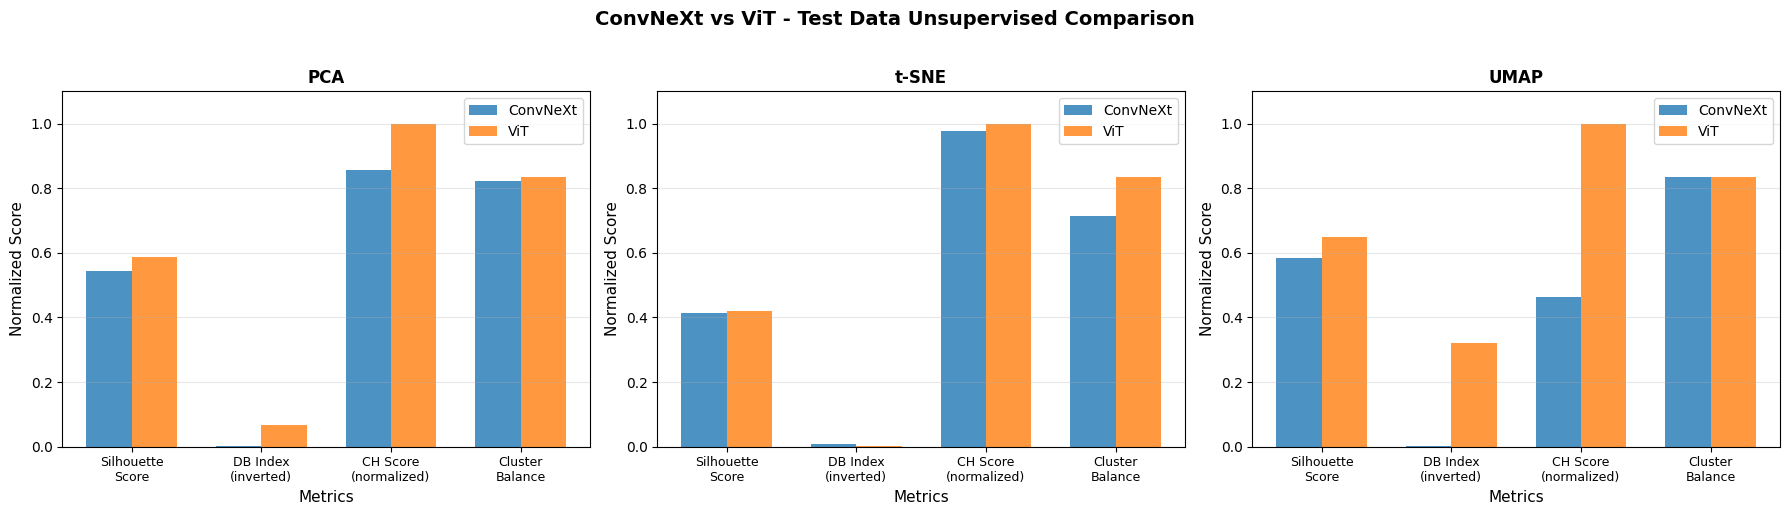


UNSUPERVISED TEST ANALYSIS COMPLETE!
All outputs saved to: outputs/test_unsupervised


In [ ]:
"""
Test Embeddings Analysis Script - UNSUPERVISED MODE
Analyzes ConvNeXt and ViT embeddings from test data WITHOUT labels.
Focuses on clustering quality and visualization to assess which model produces better structure.
"""

import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import warnings
warnings.filterwarnings('ignore')

# Try to import UMAP
try:
    from umap import UMAP
    UMAP_AVAILABLE = True
except ImportError:
    print("UMAP not available. Install with: pip install umap-learn")
    UMAP_AVAILABLE = False


class UnsupervisedEmbeddingAnalyzer:
    """Analyzer for test embeddings WITHOUT labels - focuses on intrinsic cluster quality."""

    def __init__(self, embeddings, model_name):
        """
        Initialize the unsupervised analyzer.

        Args:
            embeddings: numpy array of shape (n_samples, embedding_dim)
            model_name: str, name of the model (e.g., 'ConvNeXt', 'ViT')
        """
        self.embeddings = embeddings
        self.model_name = model_name
        self.scaler = StandardScaler()

        # Normalize embeddings
        self.embeddings_normalized = self.scaler.fit_transform(self.embeddings)

        print(f"\n{'='*60}")
        print(f"Analyzing {model_name} Embeddings - TEST DATA (Unsupervised)")
        print(f"{'='*60}")
        print(f"Embedding shape: {self.embeddings.shape}")
        print(f"Number of samples: {len(self.embeddings)}")
        print(f"Embedding dimension: {self.embeddings.shape[1]}")

    def apply_pca(self, n_components=50):
        """Apply PCA for dimensionality reduction."""
        print(f"\nApplying PCA (n_components={n_components})...")
        pca = PCA(n_components=n_components)
        embeddings_pca = pca.fit_transform(self.embeddings_normalized)

        cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
        print(f"Variance explained by {n_components} components: {cumulative_variance[-1]:.4f}")
        print(f"Variance explained by first 2 components: {cumulative_variance[1]:.4f}")

        return embeddings_pca, pca, cumulative_variance

    def apply_tsne(self, embeddings=None, perplexity=30, n_iter=1000):
        """Apply t-SNE for 2D visualization."""
        print(f"\nApplying t-SNE (perplexity={perplexity}, n_iter={n_iter})...")
        if embeddings is None:
            embeddings = self.embeddings_normalized

        tsne = TSNE(n_components=2, perplexity=perplexity, n_iter=n_iter,
                    random_state=42, verbose=0)
        embeddings_tsne = tsne.fit_transform(embeddings)
        print("t-SNE completed.")

        return embeddings_tsne

    def apply_umap(self, embeddings=None, n_neighbors=15, min_dist=0.1):
        """Apply UMAP for 2D visualization."""
        if not UMAP_AVAILABLE:
            print("UMAP not available, skipping...")
            return None

        print(f"\nApplying UMAP (n_neighbors={n_neighbors}, min_dist={min_dist})...")
        if embeddings is None:
            embeddings = self.embeddings_normalized

        umap_model = UMAP(n_components=2, n_neighbors=n_neighbors,
                         min_dist=min_dist, random_state=42)
        embeddings_umap = umap_model.fit_transform(embeddings)
        print("UMAP completed.")

        return embeddings_umap

    def perform_clustering(self, embeddings, n_clusters=2):
        """
        Perform K-means clustering and evaluate using UNSUPERVISED metrics.

        These metrics don't need true labels:
        - Silhouette Score: measures cluster cohesion and separation
        - Davies-Bouldin Index: lower is better (avg similarity between clusters)
        - Calinski-Harabasz Score: higher is better (ratio of between/within cluster dispersion)
        """
        print(f"\nPerforming K-means clustering (k={n_clusters})...")
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(embeddings)

        # Calculate unsupervised metrics
        silhouette = silhouette_score(embeddings, cluster_labels)
        davies_bouldin = davies_bouldin_score(embeddings, cluster_labels)
        calinski_harabasz = calinski_harabasz_score(embeddings, cluster_labels)

        print(f"Silhouette Score: {silhouette:.4f} (higher is better)")
        print(f"Davies-Bouldin Index: {davies_bouldin:.4f} (lower is better)")
        print(f"Calinski-Harabasz Score: {calinski_harabasz:.2f} (higher is better)")

        return cluster_labels, silhouette, davies_bouldin, calinski_harabasz

    def analyze_cluster_sizes(self, cluster_labels):
        """Analyze cluster size distribution."""
        print("\nCluster Size Distribution:")

        unique_clusters = np.unique(cluster_labels)
        sizes = []

        for cluster_id in unique_clusters:
            cluster_size = np.sum(cluster_labels == cluster_id)
            percentage = (cluster_size / len(cluster_labels)) * 100
            sizes.append(cluster_size)
            print(f"  Cluster {cluster_id}: {cluster_size} samples ({percentage:.1f}%)")

        # Check balance
        balance_ratio = min(sizes) / max(sizes) if max(sizes) > 0 else 0
        print(f"\nCluster Balance Ratio: {balance_ratio:.3f}")
        print(f"  (1.0 = perfect balance, closer to 1.0 is better)")

        return balance_ratio

    def find_optimal_k(self, embeddings, k_range=range(2, 6)):
        """
        Find optimal number of clusters using elbow method and silhouette analysis.
        For binary classification, we expect k=2 to be optimal.
        """
        print("\nFinding optimal number of clusters...")

        inertias = []
        silhouettes = []

        for k in k_range:
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            labels = kmeans.fit_predict(embeddings)

            inertias.append(kmeans.inertia_)
            if k > 1:
                silhouettes.append(silhouette_score(embeddings, labels))
            else:
                silhouettes.append(0)

        # Find optimal k based on silhouette score
        optimal_k = k_range[np.argmax(silhouettes)]
        print(f"Optimal k based on silhouette score: {optimal_k}")

        return optimal_k, list(k_range), inertias, silhouettes

    def plot_elbow_analysis(self, k_range, inertias, silhouettes, save_path=None):
        """Plot elbow curve and silhouette scores for different k values."""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

        # Elbow plot
        ax1.plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
        ax1.set_xlabel('Number of Clusters (k)', fontsize=11)
        ax1.set_ylabel('Inertia (Within-cluster sum of squares)', fontsize=11)
        ax1.set_title(f'{self.model_name} - Elbow Method', fontsize=12, fontweight='bold')
        ax1.grid(True, alpha=0.3)

        # Silhouette plot
        ax2.plot(k_range, silhouettes, 'ro-', linewidth=2, markersize=8)
        ax2.axhline(y=0.5, color='g', linestyle='--', label='Good threshold (0.5)')
        ax2.set_xlabel('Number of Clusters (k)', fontsize=11)
        ax2.set_ylabel('Silhouette Score', fontsize=11)
        ax2.set_title(f'{self.model_name} - Silhouette Analysis', fontsize=12, fontweight='bold')
        ax2.grid(True, alpha=0.3)
        ax2.legend()

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Saved: {save_path}")
        plt.show()

    def plot_variance_explained(self, cumulative_variance, save_path=None):
        """Plot cumulative variance explained by PCA components."""
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance,
                'bo-', linewidth=2, markersize=4)
        plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance')
        plt.axhline(y=0.90, color='orange', linestyle='--', label='90% Variance')
        plt.xlabel('Number of Components', fontsize=12)
        plt.ylabel('Cumulative Explained Variance', fontsize=12)
        plt.title(f'{self.model_name} - PCA Variance Explained (Test - Unsupervised)',
                 fontsize=14, fontweight='bold')
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Saved: {save_path}")
        plt.show()

    def plot_2d_embeddings(self, embeddings, method_name, cluster_labels=None, save_path=None):
        """Plot 2D embeddings colored by cluster assignments."""
        fig = plt.figure(figsize=(10, 8))

        if cluster_labels is not None:
            scatter = plt.scatter(embeddings[:, 0], embeddings[:, 1],
                                c=cluster_labels, cmap='viridis',
                                alpha=0.6, s=40, edgecolors='k', linewidth=0.5)
            cbar = plt.colorbar(scatter)
            cbar.set_label('Cluster Assignment', fontsize=11)
        else:
            plt.scatter(embeddings[:, 0], embeddings[:, 1],
                       alpha=0.6, s=40, edgecolors='k', linewidth=0.5)

        plt.xlabel(f'{method_name} Component 1', fontsize=12)
        plt.ylabel(f'{method_name} Component 2', fontsize=12)
        plt.title(f'{self.model_name} - {method_name} Visualization (Test - Unsupervised)',
                 fontsize=13, fontweight='bold')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Saved: {save_path}")
        plt.show()

    def create_comparison_plot(self, pca_2d, tsne_2d, cluster_labels,
                              umap_2d=None, save_path=None):
        """Create comparison plot of all dimensionality reduction methods."""
        n_methods = 3 if umap_2d is not None else 2
        fig, axes = plt.subplots(1, n_methods, figsize=(6*n_methods, 5))

        if n_methods == 2:
            axes = [axes[0], axes[1]]

        methods = [
            (pca_2d, 'PCA', axes[0]),
            (tsne_2d, 't-SNE', axes[1])
        ]

        if umap_2d is not None:
            methods.append((umap_2d, 'UMAP', axes[2]))

        for embeddings, name, ax in methods:
            scatter = ax.scatter(embeddings[:, 0], embeddings[:, 1],
                               c=cluster_labels, cmap='viridis',
                               alpha=0.6, s=25, edgecolors='k', linewidth=0.5)
            ax.set_xlabel(f'{name} Component 1', fontsize=10)
            ax.set_ylabel(f'{name} Component 2', fontsize=10)
            ax.set_title(f'{name}', fontsize=11, fontweight='bold')
            ax.grid(True, alpha=0.3)

        fig.colorbar(scatter, ax=axes, label='Cluster', fraction=0.046, pad=0.04)

        fig.suptitle(f'{self.model_name} - Dimensionality Reduction Comparison (Test - Unsupervised)',
                    fontsize=14, fontweight='bold', y=1.02)
        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Saved: {save_path}")
        plt.show()

    def generate_summary_report(self, metrics_dict, balance_ratios, save_path=None):
        """Generate comprehensive unsupervised test summary report."""
        report = f"\n{'='*70}\n"
        report += f"{self.model_name} EMBEDDINGS ANALYSIS - TEST DATA (UNSUPERVISED)\n"
        report += f"{'='*70}\n\n"

        report += f"Dataset Information:\n"
        report += f"  - Total samples: {len(self.embeddings)}\n"
        report += f"  - Embedding dimension: {self.embeddings.shape[1]}\n\n"

        report += f"Unsupervised Clustering Results:\n"
        report += f"Note: These metrics don't require true labels\n\n"

        for method, metrics in metrics_dict.items():
            report += f"  {method}:\n"
            for metric_name, value in metrics.items():
                if metric_name == 'Davies-Bouldin Index':
                    report += f"    - {metric_name}: {value:.4f} (lower is better)\n"
                elif metric_name == 'Calinski-Harabasz Score':
                    report += f"    - {metric_name}: {value:.2f} (higher is better)\n"
                else:
                    report += f"    - {metric_name}: {value:.4f}\n"

            if method in balance_ratios:
                report += f"    - Cluster Balance: {balance_ratios[method]:.3f}\n"
            report += "\n"

        report += f"{'='*70}\n"
        report += "INTERPRETATION GUIDE:\n"
        report += "  - Silhouette Score > 0.5: Well-defined clusters\n"
        report += "  - Davies-Bouldin < 1.0: Good cluster separation\n"
        report += "  - Balance Ratio > 0.7: Balanced cluster sizes\n"
        report += f"{'='*70}\n"

        print(report)

        if save_path:
            with open(save_path, 'w') as f:
                f.write(report)
            print(f"Report saved to: {save_path}")

        return report


def load_test_embeddings_no_labels(convnext_path, vit_path):
    """Load test embeddings WITHOUT labels."""
    print("Loading test embeddings (no labels)...")

    with open(convnext_path, 'rb') as f:
        convnext_embeddings = pickle.load(f)

    with open(vit_path, 'rb') as f:
        vit_embeddings = pickle.load(f)

    # Ensure numpy arrays
    convnext_embeddings = np.array(convnext_embeddings)
    vit_embeddings = np.array(vit_embeddings)

    print(f"Loaded ConvNeXt test embeddings: {convnext_embeddings.shape}")
    print(f"Loaded ViT test embeddings: {vit_embeddings.shape}")

    return convnext_embeddings, vit_embeddings


def analyze_test_embeddings_unsupervised(embeddings, model_name, output_dir='outputs/test'):
    """Complete unsupervised analysis pipeline for test embeddings."""
    import os
    os.makedirs(output_dir, exist_ok=True)

    # Initialize analyzer
    analyzer = UnsupervisedEmbeddingAnalyzer(embeddings, model_name)

    # Apply PCA
    embeddings_pca, pca, cumulative_variance = analyzer.apply_pca(n_components=50)
    analyzer.plot_variance_explained(
        cumulative_variance,
        save_path=f'{output_dir}/{model_name.lower()}_pca_variance.png'
    )

    pca_2d = embeddings_pca[:, :2]

    # Find optimal k
    optimal_k, k_range, inertias, silhouettes = analyzer.find_optimal_k(embeddings_pca)
    analyzer.plot_elbow_analysis(
        k_range, inertias, silhouettes,
        save_path=f'{output_dir}/{model_name.lower()}_elbow_analysis.png'
    )

    # Apply t-SNE
    tsne_2d = analyzer.apply_tsne(embeddings_pca, perplexity=30, n_iter=1000)

    # Apply UMAP if available
    umap_2d = analyzer.apply_umap(embeddings_pca, n_neighbors=15, min_dist=0.1)

    # Clustering analysis with k=2 (binary classification)
    metrics_dict = {}
    balance_ratios = {}

    # PCA clustering
    cluster_labels_pca, sil_pca, db_pca, ch_pca = analyzer.perform_clustering(pca_2d, n_clusters=2)
    balance_pca = analyzer.analyze_cluster_sizes(cluster_labels_pca)
    metrics_dict['PCA'] = {
        'Silhouette Score': sil_pca,
        'Davies-Bouldin Index': db_pca,
        'Calinski-Harabasz Score': ch_pca
    }
    balance_ratios['PCA'] = balance_pca

    # t-SNE clustering
    cluster_labels_tsne, sil_tsne, db_tsne, ch_tsne = analyzer.perform_clustering(tsne_2d, n_clusters=2)
    balance_tsne = analyzer.analyze_cluster_sizes(cluster_labels_tsne)
    metrics_dict['t-SNE'] = {
        'Silhouette Score': sil_tsne,
        'Davies-Bouldin Index': db_tsne,
        'Calinski-Harabasz Score': ch_tsne
    }
    balance_ratios['t-SNE'] = balance_tsne

    # UMAP clustering
    if umap_2d is not None:
        cluster_labels_umap, sil_umap, db_umap, ch_umap = analyzer.perform_clustering(umap_2d, n_clusters=2)
        balance_umap = analyzer.analyze_cluster_sizes(cluster_labels_umap)
        metrics_dict['UMAP'] = {
            'Silhouette Score': sil_umap,
            'Davies-Bouldin Index': db_umap,
            'Calinski-Harabasz Score': ch_umap
        }
        balance_ratios['UMAP'] = balance_umap

    # Visualizations
    print("\nGenerating test visualizations...")

    # PCA plot
    analyzer.plot_2d_embeddings(
        pca_2d, 'PCA', cluster_labels_pca,
        save_path=f'{output_dir}/{model_name.lower()}_pca_visualization.png'
    )

    # t-SNE plot
    analyzer.plot_2d_embeddings(
        tsne_2d, 't-SNE', cluster_labels_tsne,
        save_path=f'{output_dir}/{model_name.lower()}_tsne_visualization.png'
    )

    # UMAP plot
    if umap_2d is not None:
        analyzer.plot_2d_embeddings(
            umap_2d, 'UMAP', cluster_labels_umap,
            save_path=f'{output_dir}/{model_name.lower()}_umap_visualization.png'
        )

    # Comparison plot
    analyzer.create_comparison_plot(
        pca_2d, tsne_2d, cluster_labels_tsne, umap_2d,
        save_path=f'{output_dir}/{model_name.lower()}_comparison.png'
    )

    # Generate report
    analyzer.generate_summary_report(
        metrics_dict, balance_ratios,
        save_path=f'{output_dir}/{model_name.lower()}_analysis_report.txt'
    )

    return metrics_dict, balance_ratios


def create_final_comparison_unsupervised(convnext_metrics, vit_metrics,
                                         convnext_balance, vit_balance, output_dir):
    """Create final comparison between ConvNeXt and ViT using unsupervised metrics."""

    report = f"\n{'='*70}\n"
    report += "FINAL MODEL COMPARISON - TEST DATA (UNSUPERVISED)\n"
    report += f"{'='*70}\n\n"

    report += "Performance Comparison (without true labels):\n"
    report += f"{'Method':<15} {'Metric':<30} {'ConvNeXt':<12} {'ViT':<12} {'Winner':<10}\n"
    report += "-" * 70 + "\n"

    winners = {'ConvNeXt': 0, 'ViT': 0}

    for method in convnext_metrics.keys():
        for metric in convnext_metrics[method].keys():
            conv_val = convnext_metrics[method][metric]
            vit_val = vit_metrics[method][metric]

            # For Davies-Bouldin, lower is better
            if metric == 'Davies-Bouldin Index':
                winner = "ConvNeXt" if conv_val < vit_val else "ViT"
            else:  # For Silhouette and Calinski-Harabasz, higher is better
                winner = "ConvNeXt" if conv_val > vit_val else "ViT"

            winners[winner] += 1

            if metric == 'Calinski-Harabasz Score':
                report += f"{method:<15} {metric:<30} {conv_val:<12.2f} {vit_val:<12.2f} {winner:<10}\n"
            else:
                report += f"{method:<15} {metric:<30} {conv_val:<12.4f} {vit_val:<12.4f} {winner:<10}\n"

        # Add balance ratio
        if method in convnext_balance and method in vit_balance:
            conv_bal = convnext_balance[method]
            vit_bal = vit_balance[method]
            winner = "ConvNeXt" if conv_bal > vit_bal else "ViT"
            winners[winner] += 1

            report += f"{method:<15} {'Cluster Balance':<30} {conv_bal:<12.3f} {vit_bal:<12.3f} {winner:<10}\n"

        report += "\n"

    report += f"\n{'='*70}\n"
    report += "OVERALL WINNER:\n"
    report += f"  ConvNeXt wins: {winners['ConvNeXt']} metrics\n"
    report += f"  ViT wins:      {winners['ViT']} metrics\n"

    overall_winner = "ConvNeXt" if winners['ConvNeXt'] > winners['ViT'] else "ViT"
    report += f"\n  RECOMMENDED MODEL: {overall_winner}\n"
    report += f"{'='*70}\n"

    report += "\nInterpretation (Unsupervised):\n"
    report += f"  - {overall_winner} shows better intrinsic clustering structure\n"
    report += "  - Higher silhouette score = better-defined clusters\n"
    report += "  - Lower Davies-Bouldin = better cluster separation\n"
    report += "  - Higher Calinski-Harabasz = better cluster density\n\n"

    report += "Recommendations:\n"
    report += f"  1. Use {overall_winner} embeddings for downstream tasks\n"
    report += "  2. The better clustering suggests this model captures\n"
    report += "     more discriminative features for your SAR dataset\n"
    report += "  3. When you get test labels, validate this recommendation\n"
    report += f"{'='*70}\n"

    print(report)

    # Save report
    import os
    os.makedirs(output_dir, exist_ok=True)
    with open(f'{output_dir}/final_comparison_report.txt', 'w') as f:
        f.write(report)
    print(f"Final report saved to: {output_dir}/final_comparison_report.txt")

    # Create visual comparison
    create_visual_comparison_unsupervised(convnext_metrics, vit_metrics,
                                         convnext_balance, vit_balance, output_dir)


def create_visual_comparison_unsupervised(convnext_metrics, vit_metrics,
                                         convnext_balance, vit_balance, output_dir):
    """Create visual comparison plots for unsupervised metrics."""

    methods = list(convnext_metrics.keys())
    n_methods = len(methods)

    fig, axes = plt.subplots(1, n_methods, figsize=(6*n_methods, 5))
    if n_methods == 1:
        axes = [axes]

    for idx, method in enumerate(methods):
        metric_names = []
        convnext_vals = []
        vit_vals = []

        # Normalize metrics to 0-1 scale for visual comparison
        for metric in convnext_metrics[method].keys():
            if metric == 'Silhouette Score':
                metric_names.append('Silhouette\nScore')
                convnext_vals.append(convnext_metrics[method][metric])
                vit_vals.append(vit_metrics[method][metric])
            elif metric == 'Davies-Bouldin Index':
                # Invert so higher is better (for visualization consistency)
                metric_names.append('DB Index\n(inverted)')
                conv_db = convnext_metrics[method][metric]
                vit_db = vit_metrics[method][metric]
                # Normalize and invert
                max_db = max(conv_db, vit_db)
                convnext_vals.append(1 - (conv_db / (max_db + 0.001)))
                vit_vals.append(1 - (vit_db / (max_db + 0.001)))
            elif metric == 'Calinski-Harabasz Score':
                # Normalize to 0-1
                metric_names.append('CH Score\n(normalized)')
                conv_ch = convnext_metrics[method][metric]
                vit_ch = vit_metrics[method][metric]
                max_ch = max(conv_ch, vit_ch)
                convnext_vals.append(conv_ch / (max_ch + 0.001))
                vit_vals.append(vit_ch / (max_ch + 0.001))

        # Add balance
        if method in convnext_balance:
            metric_names.append('Cluster\nBalance')
            convnext_vals.append(convnext_balance[method])
            vit_vals.append(vit_balance[method])

        x = np.arange(len(metric_names))
        width = 0.35

        axes[idx].bar(x - width/2, convnext_vals, width, label='ConvNeXt', alpha=0.8)
        axes[idx].bar(x + width/2, vit_vals, width, label='ViT', alpha=0.8)

        axes[idx].set_xlabel('Metrics', fontsize=11)
        axes[idx].set_ylabel('Normalized Score', fontsize=11)
        axes[idx].set_title(f'{method}', fontsize=12, fontweight='bold')
        axes[idx].set_xticks(x)
        axes[idx].set_xticklabels(metric_names, fontsize=9)
        axes[idx].legend()
        axes[idx].grid(True, alpha=0.3, axis='y')
        axes[idx].set_ylim([0, 1.1])

    fig.suptitle('ConvNeXt vs ViT - Test Data Unsupervised Comparison',
                fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()

    save_path = f'{output_dir}/final_comparison_plot.png'
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Saved comparison plot: {save_path}")
    plt.show()


def main():
    """Main execution function for unsupervised test analysis."""
    # =================================================================
    # CONFIGURATION - UPDATE THESE PATHS
    # =================================================================
    CONVNEXT_TEST_PATH = '/content/convnext_test_embeddings.pkl'
    VIT_TEST_PATH = '/content/vit_test_embeddings.pkl'
    # NO LABELS NEEDED!
    OUTPUT_DIR = 'outputs/test_unsupervised'

    # =================================================================

    print("\n" + "="*70)
    print("TEST EMBEDDINGS ANALYSIS - UNSUPERVISED MODE")
    print("(No labels required)")
    print("="*70)

    # Load test embeddings (no labels)
    convnext_embeddings, vit_embeddings = load_test_embeddings_no_labels(
        CONVNEXT_TEST_PATH, VIT_TEST_PATH
    )

    # Analyze ConvNeXt test embeddings
    print("\n" + "="*70)
    print("ANALYZING CONVNEXT TEST EMBEDDINGS")
    print("="*70)
    convnext_metrics, convnext_balance = analyze_test_embeddings_unsupervised(
        convnext_embeddings, 'ConvNeXt',
        output_dir=f'{OUTPUT_DIR}/convnext'
    )

    # Analyze ViT test embeddings
    print("\n" + "="*70)
    print("ANALYZING VIT TEST EMBEDDINGS")
    print("="*70)
    vit_metrics, vit_balance = analyze_test_embeddings_unsupervised(
        vit_embeddings, 'ViT',
        output_dir=f'{OUTPUT_DIR}/vit'
    )

    # Final comparison
    print("\n" + "="*70)
    print("CREATING FINAL COMPARISON")
    print("="*70)
    create_final_comparison_unsupervised(convnext_metrics, vit_metrics,
                                         convnext_balance, vit_balance, OUTPUT_DIR)

    print("\n" + "="*70)
    print("UNSUPERVISED TEST ANALYSIS COMPLETE!")
    print(f"All outputs saved to: {OUTPUT_DIR}")
    print("="*70)


if __name__ == "__main__":
    main()


MILESTONE 3: FAST EMBEDDING CLASSIFICATION
Loading embeddings and labels...
Loaded train embeddings: (1604, 768)
Loaded test embeddings: (8424, 768)
Loaded train labels: (1604,)

FAST EMBEDDING CLASSIFIER - ViT Embeddings
Training set: 1443 samples
Validation set: 161 samples (10%)
Test set: 8424 samples
Embedding dimension: 768

Using DEFAULT hyperparameters (NO tuning for speed)

TRAINING ALL CLASSIFIERS (Fast Mode)


----------------------------------------------------------------------
Training: Logistic Regression
----------------------------------------------------------------------
Training time: 4.52s

  Training:   Acc=0.9688  Prec=0.9647  Rec=0.9690  F1=0.9668
  Validation: Acc=0.7081  Prec=0.6986  Rec=0.6711  F1=0.6846

----------------------------------------------------------------------
Training: SVM
----------------------------------------------------------------------
Training time: 3.00s

  Training:   Acc=0.9827  Prec=0.9822  Rec=0.9808  F1=0.9815
  Validation: Acc=0

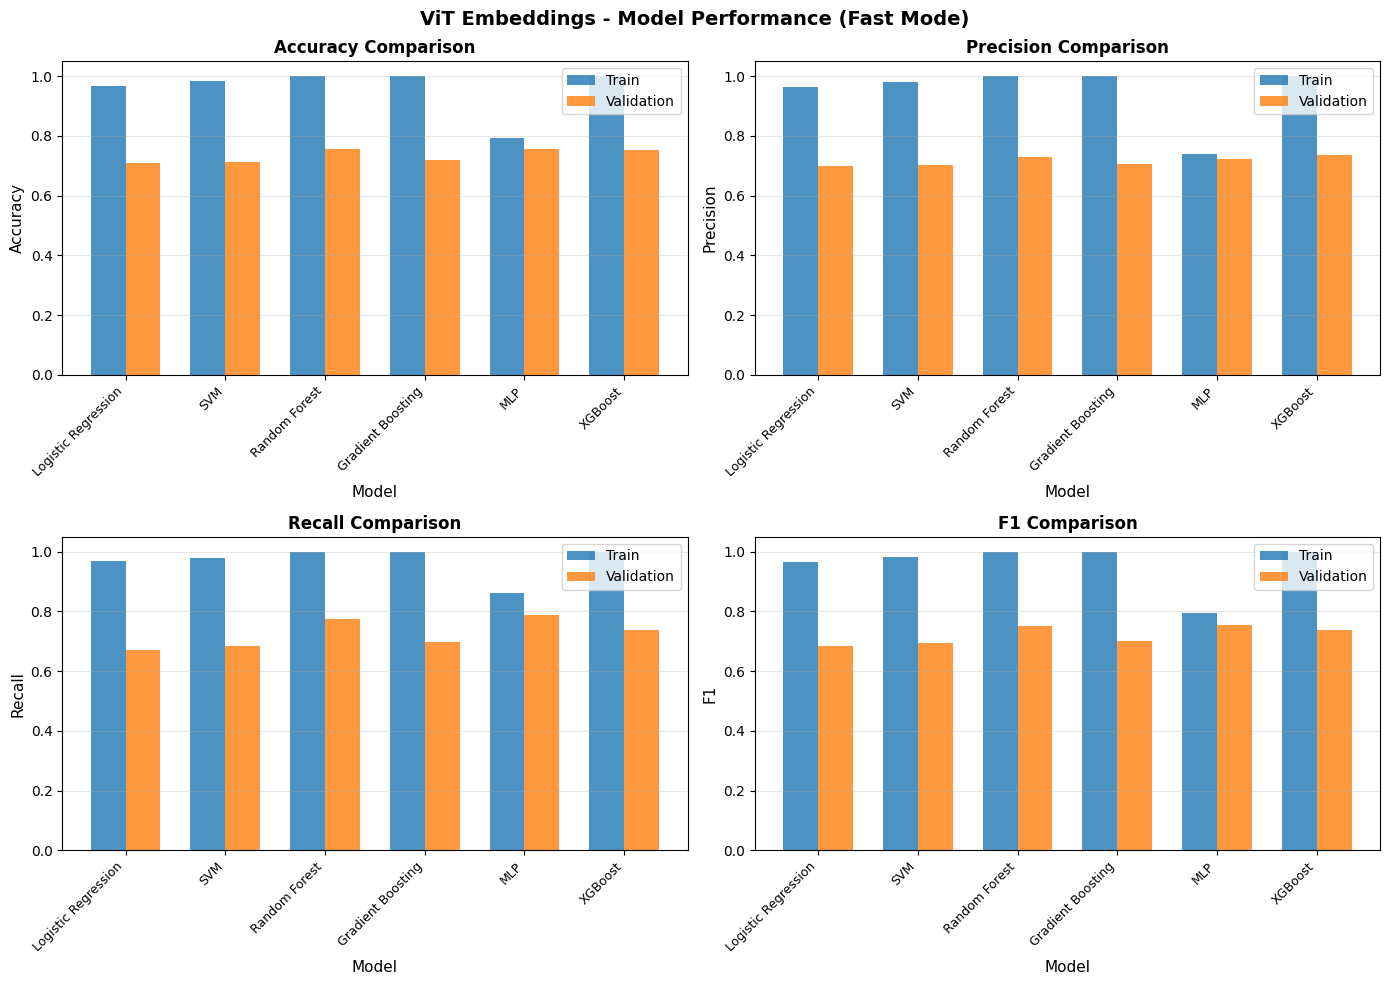


MILESTONE 3: FAST CLASSIFIER RESULTS - ViT

Training Mode: FAST (Default hyperparameters)
Total Training Time: 98.44s

Dataset Split:
  Training:   1443 samples
  Validation: 161 samples
  Test:       8424 samples



✅ Best model saved: outputs/milestone3_fast/best_model_mlp.pkl
✅ All results saved: outputs/milestone3_fast/all_results.pkl
✅ Results saved as JSON: outputs/milestone3_fast/results.json

BEST MODEL: MLP

📁 Saved Files:
  - outputs/milestone3_fast/best_model_mlp.pkl
  - outputs/milestone3_fast/all_results.pkl
  - outputs/milestone3_fast/results.json
  - outputs/milestone3_fast/classification_report.txt
  - outputs/milestone3_fast/model_comparison.png

All outputs saved to: outputs/milestone3_fast


In [ ]:
"""
Milestone 3: Embedding-Based Classification - FAST VERSION
Uses sensible default hyperparameters instead of grid search.
Runs in ~5-10 minutes instead of 30+ minutes.
"""

import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (classification_report, confusion_matrix,
                            precision_score, recall_score, f1_score,
                            accuracy_score, roc_auc_score, roc_curve)
import warnings
import time
warnings.filterwarnings('ignore')

# Try to import XGBoost
try:
    from xgboost import XGBClassifier
    XGBOOST_AVAILABLE = True
except ImportError:
    print("XGBoost not available. Install with: pip install xgboost")
    XGBOOST_AVAILABLE = False


class FastEmbeddingClassifier:
    """Fast classifier trainer using good default hyperparameters."""

    def __init__(self, embeddings_train, labels_train, embeddings_test,
                 labels_test=None, model_name='ViT', val_split=0.1, random_state=42):
        """Initialize fast classifier trainer."""
        self.model_name = model_name
        self.random_state = random_state
        self.val_split = val_split

        # Split training data
        self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(
            embeddings_train, labels_train,
            test_size=val_split,
            random_state=random_state,
            stratify=labels_train
        )

        self.X_test = embeddings_test
        self.y_test = labels_test

        # Standardize features
        self.scaler = StandardScaler()
        self.X_train_scaled = self.scaler.fit_transform(self.X_train)
        self.X_val_scaled = self.scaler.transform(self.X_val)
        self.X_test_scaled = self.scaler.transform(self.X_test)

        print(f"\n{'='*70}")
        print(f"FAST EMBEDDING CLASSIFIER - {model_name} Embeddings")
        print(f"{'='*70}")
        print(f"Training set: {self.X_train.shape[0]} samples")
        print(f"Validation set: {self.X_val.shape[0]} samples ({val_split*100:.0f}%)")
        print(f"Test set: {self.X_test.shape[0]} samples")
        print(f"Embedding dimension: {self.X_train.shape[1]}")
        print(f"\nUsing DEFAULT hyperparameters (NO tuning for speed)")

        self.trained_models = {}
        self.results = {}
        self.training_times = {}

    def _evaluate_model(self, model, model_name):
        """Evaluate model on all sets."""
        # Training set
        y_train_pred = model.predict(self.X_train_scaled)
        train_accuracy = accuracy_score(self.y_train, y_train_pred)
        train_precision = precision_score(self.y_train, y_train_pred)
        train_recall = recall_score(self.y_train, y_train_pred)
        train_f1 = f1_score(self.y_train, y_train_pred)

        # Validation set
        y_val_pred = model.predict(self.X_val_scaled)
        val_accuracy = accuracy_score(self.y_val, y_val_pred)
        val_precision = precision_score(self.y_val, y_val_pred)
        val_recall = recall_score(self.y_val, y_val_pred)
        val_f1 = f1_score(self.y_val, y_val_pred)

        print(f"\n  Training:   Acc={train_accuracy:.4f}  Prec={train_precision:.4f}  Rec={train_recall:.4f}  F1={train_f1:.4f}")
        print(f"  Validation: Acc={val_accuracy:.4f}  Prec={val_precision:.4f}  Rec={val_recall:.4f}  F1={val_f1:.4f}")

        results = {
            'train': {'accuracy': train_accuracy, 'precision': train_precision,
                     'recall': train_recall, 'f1': train_f1},
            'val': {'accuracy': val_accuracy, 'precision': val_precision,
                   'recall': val_recall, 'f1': val_f1}
        }

        # Test set evaluation
        if self.y_test is not None:
            y_test_pred = model.predict(self.X_test_scaled)
            y_test_proba = model.predict_proba(self.X_test_scaled)[:, 1]

            test_accuracy = accuracy_score(self.y_test, y_test_pred)
            test_precision = precision_score(self.y_test, y_test_pred)
            test_recall = recall_score(self.y_test, y_test_pred)
            test_f1 = f1_score(self.y_test, y_test_pred)
            test_auc = roc_auc_score(self.y_test, y_test_proba)

            print(f"  Test:       Acc={test_accuracy:.4f}  Prec={test_precision:.4f}  Rec={test_recall:.4f}  F1={test_f1:.4f}  AUC={test_auc:.4f}")

            results['test'] = {
                'accuracy': test_accuracy, 'precision': test_precision,
                'recall': test_recall, 'f1': test_f1, 'auc': test_auc,
                'predictions': y_test_pred, 'probabilities': y_test_proba
            }

        self.results[model_name] = results

    def train_all_models(self):
        """Train all classifiers with good default hyperparameters."""
        print(f"\n{'='*70}")
        print(f"TRAINING ALL CLASSIFIERS (Fast Mode)")
        print(f"{'='*70}\n")

        models = [
            ('Logistic Regression', LogisticRegression(
                C=1.0, max_iter=1000, random_state=self.random_state
            )),
            ('SVM', SVC(
                C=10, kernel='rbf', gamma='scale', probability=True,
                random_state=self.random_state
            )),
            ('Random Forest', RandomForestClassifier(
                n_estimators=200, max_depth=20, min_samples_split=5,
                random_state=self.random_state, n_jobs=-1
            )),
            ('Gradient Boosting', GradientBoostingClassifier(
                n_estimators=100, learning_rate=0.1, max_depth=5,
                random_state=self.random_state
            )),
            ('MLP', MLPClassifier(
                hidden_layer_sizes=(256, 128), alpha=0.001,
                learning_rate_init=0.001, max_iter=300,
                early_stopping=True, random_state=self.random_state
            ))
        ]

        # Add XGBoost if available
        if XGBOOST_AVAILABLE:
            models.append(('XGBoost', XGBClassifier(
                n_estimators=200, learning_rate=0.1, max_depth=5,
                random_state=self.random_state, eval_metric='logloss'
            )))

        for model_name, model in models:
            print(f"\n{'-'*70}")
            print(f"Training: {model_name}")
            print(f"{'-'*70}")

            start_time = time.time()
            model.fit(self.X_train_scaled, self.y_train)
            training_time = time.time() - start_time

            self.training_times[model_name] = training_time
            print(f"Training time: {training_time:.2f}s")

            self.trained_models[model_name] = model
            self._evaluate_model(model, model_name)

        print(f"\n{'='*70}")
        print("ALL MODELS TRAINED!")
        print(f"{'='*70}")

        # Print training time summary
        print(f"\nTraining Time Summary:")
        for name, t in self.training_times.items():
            print(f"  {name:<25} {t:>6.2f}s")
        print(f"  {'TOTAL':<25} {sum(self.training_times.values()):>6.2f}s")

    def plot_results_comparison(self, save_path=None):
        """Plot comparison of all models."""
        models = list(self.results.keys())
        metrics = ['accuracy', 'precision', 'recall', 'f1']

        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        axes = axes.flatten()

        for idx, metric in enumerate(metrics):
            train_vals = [self.results[m]['train'][metric] for m in models]
            val_vals = [self.results[m]['val'][metric] for m in models]

            x = np.arange(len(models))
            width = 0.35

            axes[idx].bar(x - width/2, train_vals, width, label='Train', alpha=0.8)
            axes[idx].bar(x + width/2, val_vals, width, label='Validation', alpha=0.8)

            if 'test' in self.results[models[0]]:
                test_vals = [self.results[m]['test'][metric] for m in models]
                axes[idx].scatter(x, test_vals, color='red', s=100,
                                marker='D', label='Test', zorder=3)

            axes[idx].set_xlabel('Model', fontsize=11)
            axes[idx].set_ylabel(metric.capitalize(), fontsize=11)
            axes[idx].set_title(f'{metric.capitalize()} Comparison',
                              fontsize=12, fontweight='bold')
            axes[idx].set_xticks(x)
            axes[idx].set_xticklabels(models, rotation=45, ha='right', fontsize=9)
            axes[idx].legend()
            axes[idx].grid(True, alpha=0.3, axis='y')
            axes[idx].set_ylim([0, 1.05])

        plt.suptitle(f'{self.model_name} Embeddings - Model Performance (Fast Mode)',
                    fontsize=14, fontweight='bold')
        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Saved: {save_path}")
        plt.show()

    def plot_confusion_matrices(self, save_path=None):
        """Plot confusion matrices for all models."""
        if self.y_test is None:
            print("Test labels not available. Skipping confusion matrices.")
            return

        n_models = len(self.trained_models)
        n_cols = 3
        n_rows = (n_models + n_cols - 1) // n_cols

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
        axes = axes.flatten() if n_models > 1 else [axes]

        for idx, (model_name, model) in enumerate(self.trained_models.items()):
            y_pred = self.results[model_name]['test']['predictions']
            cm = confusion_matrix(self.y_test, y_pred)

            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                       xticklabels=['Ship', 'Iceberg'],
                       yticklabels=['Ship', 'Iceberg'])
            axes[idx].set_xlabel('Predicted', fontsize=10)
            axes[idx].set_ylabel('True', fontsize=10)
            axes[idx].set_title(f'{model_name}', fontsize=11, fontweight='bold')

        for idx in range(len(self.trained_models), len(axes)):
            axes[idx].axis('off')

        plt.suptitle(f'{self.model_name} - Confusion Matrices (Fast Mode)',
                    fontsize=14, fontweight='bold')
        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Saved: {save_path}")
        plt.show()

    def plot_roc_curves(self, save_path=None):
        """Plot ROC curves."""
        if self.y_test is None:
            return

        plt.figure(figsize=(10, 8))

        for model_name in self.results.keys():
            if 'test' in self.results[model_name]:
                y_proba = self.results[model_name]['test']['probabilities']
                fpr, tpr, _ = roc_curve(self.y_test, y_proba)
                auc = self.results[model_name]['test']['auc']
                plt.plot(fpr, tpr, linewidth=2, label=f'{model_name} (AUC={auc:.3f})')

        plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random')
        plt.xlabel('False Positive Rate', fontsize=12)
        plt.ylabel('True Positive Rate', fontsize=12)
        plt.title(f'{self.model_name} - ROC Curves (Fast Mode)', fontsize=14, fontweight='bold')
        plt.legend(loc='lower right', fontsize=10)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Saved: {save_path}")
        plt.show()

    def generate_summary_report(self, save_path=None):
        """Generate summary report."""
        report = f"\n{'='*70}\n"
        report += f"MILESTONE 3: FAST CLASSIFIER RESULTS - {self.model_name}\n"
        report += f"{'='*70}\n\n"

        report += f"Training Mode: FAST (Default hyperparameters)\n"
        report += f"Total Training Time: {sum(self.training_times.values()):.2f}s\n\n"

        report += f"Dataset Split:\n"
        report += f"  Training:   {len(self.y_train)} samples\n"
        report += f"  Validation: {len(self.y_val)} samples\n"
        report += f"  Test:       {len(self.X_test)} samples\n\n"

        if self.y_test is not None:
            report += f"{'Model':<25} {'Val F1':<10} {'Test F1':<10} {'Test Prec':<10} {'Test Rec':<10}\n"
            report += f"{'-'*70}\n"

            for model_name in self.results.keys():
                val_f1 = self.results[model_name]['val']['f1']
                test_f1 = self.results[model_name]['test']['f1']
                test_prec = self.results[model_name]['test']['precision']
                test_rec = self.results[model_name]['test']['recall']

                report += f"{model_name:<25} {val_f1:<10.4f} {test_f1:<10.4f} {test_prec:<10.4f} {test_rec:<10.4f}\n"

        # Find best model
        if self.y_test is not None:
            best_model = max(self.results.keys(),
                           key=lambda x: self.results[x]['test']['f1'])
            best_f1 = self.results[best_model]['test']['f1']

            report += f"\n{'='*70}\n"
            report += f"BEST MODEL: {best_model}\n"
            report += f"  Test F1:  {best_f1:.4f}\n"
            report += f"{'='*70}\n"

        print(report)

        if save_path:
            with open(save_path, 'w') as f:
                f.write(report)

        return report

    def get_best_model(self):
        """Return best model."""
        if self.y_test is not None:
            best_name = max(self.results.keys(),
                          key=lambda x: self.results[x]['test']['f1'])
        else:
            best_name = max(self.results.keys(),
                          key=lambda x: self.results[x]['val']['f1'])
        return best_name, self.trained_models[best_name]


def load_embeddings_and_labels(train_emb_path, test_emb_path, train_labels_path,
                               test_labels_path=None):
    """Load embeddings and labels."""
    print("Loading embeddings and labels...")

    with open(train_emb_path, 'rb') as f:
        train_embeddings = np.array(pickle.load(f))

    with open(test_emb_path, 'rb') as f:
        test_embeddings = np.array(pickle.load(f))

    with open(train_labels_path, 'rb') as f:
        train_labels = np.array(pickle.load(f))

    test_labels = None
    if test_labels_path:
        try:
            with open(test_labels_path, 'rb') as f:
                test_labels = np.array(pickle.load(f))
        except:
            pass

    print(f"Loaded train embeddings: {train_embeddings.shape}")
    print(f"Loaded test embeddings: {test_embeddings.shape}")
    print(f"Loaded train labels: {train_labels.shape}")

    return train_embeddings, test_embeddings, train_labels, test_labels


def main():
    """Main execution - FAST VERSION."""
    # =================================================================
    # CONFIGURATION
    # =================================================================
    TRAIN_EMBEDDINGS_PATH = '/content/vit_train_embeddings.pkl'
    TEST_EMBEDDINGS_PATH = '/content/vit_test_embeddings.pkl'
    TRAIN_LABELS_PATH = '/content/train_labels.pkl'
    TEST_LABELS_PATH = None  # Optional

    OUTPUT_DIR = 'outputs/milestone3_fast'
    VAL_SPLIT = 0.1
    # =================================================================

    import os
    os.makedirs(OUTPUT_DIR, exist_ok=True)

    print("\n" + "="*70)
    print("MILESTONE 3: FAST EMBEDDING CLASSIFICATION")
    print("="*70)

    # Load data
    train_emb, test_emb, train_labels, test_labels = load_embeddings_and_labels(
        TRAIN_EMBEDDINGS_PATH, TEST_EMBEDDINGS_PATH,
        TRAIN_LABELS_PATH, TEST_LABELS_PATH
    )

    # Train classifiers
    classifier = FastEmbeddingClassifier(
        train_emb, train_labels, test_emb, test_labels,
        model_name='ViT', val_split=VAL_SPLIT, random_state=42
    )

    classifier.train_all_models()

    # Generate outputs
    print("\nGenerating visualizations...")
    classifier.plot_results_comparison(f'{OUTPUT_DIR}/model_comparison.png')

    if test_labels is not None:
        classifier.plot_confusion_matrices(f'{OUTPUT_DIR}/confusion_matrices.png')
        classifier.plot_roc_curves(f'{OUTPUT_DIR}/roc_curves.png')

    classifier.generate_summary_report(f'{OUTPUT_DIR}/classification_report.txt')

    # Save best model with complete information
    best_name, best_model = classifier.get_best_model()

    # Save best model
    best_model_data = {
        'model': best_model,
        'scaler': classifier.scaler,
        'name': best_name
    }

    best_model_filename = f'{OUTPUT_DIR}/best_model_{best_name.lower().replace(" ", "_")}.pkl'
    with open(best_model_filename, 'wb') as f:
        pickle.dump(best_model_data, f)
    print(f"\n✅ Best model saved: {best_model_filename}")

    # Save ALL results for comparison script
    all_results = {
        'model_name': classifier.model_name,
        'val_split': classifier.val_split,
        'best_model_name': best_name,
        'results': classifier.results,
        'training_times': classifier.training_times
    }

    results_filename = f'{OUTPUT_DIR}/all_results.pkl'
    with open(results_filename, 'wb') as f:
        pickle.dump(all_results, f)
    print(f"✅ All results saved: {results_filename}")

    # Also save results as JSON for easy viewing
    import json

    # Convert results to JSON-serializable format
    json_results = {}
    for model_name, results in classifier.results.items():
        json_results[model_name] = {
            'train': results['train'],
            'val': results['val']
        }
        if 'test' in results:
            json_results[model_name]['test'] = {
                'accuracy': float(results['test']['accuracy']),
                'precision': float(results['test']['precision']),
                'recall': float(results['test']['recall']),
                'f1': float(results['test']['f1']),
                'auc': float(results['test']['auc'])
            }

    json_filename = f'{OUTPUT_DIR}/results.json'
    with open(json_filename, 'w') as f:
        json.dump(json_results, f, indent=4)
    print(f"✅ Results saved as JSON: {json_filename}")

    print(f"\n{'='*70}")
    print(f"BEST MODEL: {best_name}")
    print(f"\n📁 Saved Files:")
    print(f"  - {best_model_filename}")
    print(f"  - {results_filename}")
    print(f"  - {json_filename}")
    print(f"  - {OUTPUT_DIR}/classification_report.txt")
    print(f"  - {OUTPUT_DIR}/model_comparison.png")
    if test_labels is not None:
        print(f"  - {OUTPUT_DIR}/confusion_matrices.png")
        print(f"  - {OUTPUT_DIR}/roc_curves.png")
    print(f"\nAll outputs saved to: {OUTPUT_DIR}")
    print(f"{'='*70}")


if __name__ == "__main__":
    main()


MILESTONE 3: TEST SET EVALUATION
Loading best model from: /content/outputs/milestone3_fast/best_model_mlp.pkl
✅ Loaded: MLP

Loading test data...
✅ Test embeddings: (8424, 768)

EVALUATING ON TEST SET

Generating predictions...
✅ Generated 8424 predictions

Prediction Distribution:
  Predicted Ships (0):    6242 (74.1%)
  Predicted Icebergs (1): 2182 (25.9%)

Probability Statistics:
  Mean probability: 0.2908
  Std probability:  0.3005
  Min probability:  0.0000
  Max probability:  0.9997

⚠️  No test labels available - cannot calculate precision/recall
   Predictions will be saved for Kaggle submission

CREATING SUBMISSION FILE
✅ Saved: outputs/milestone3_test_evaluation/submission.csv
   Format: id, is_iceberg (probability)
   Ready for Kaggle submission!

Generating visualizations...
✅ Saved: outputs/milestone3_test_evaluation/test_predictions_distribution.png


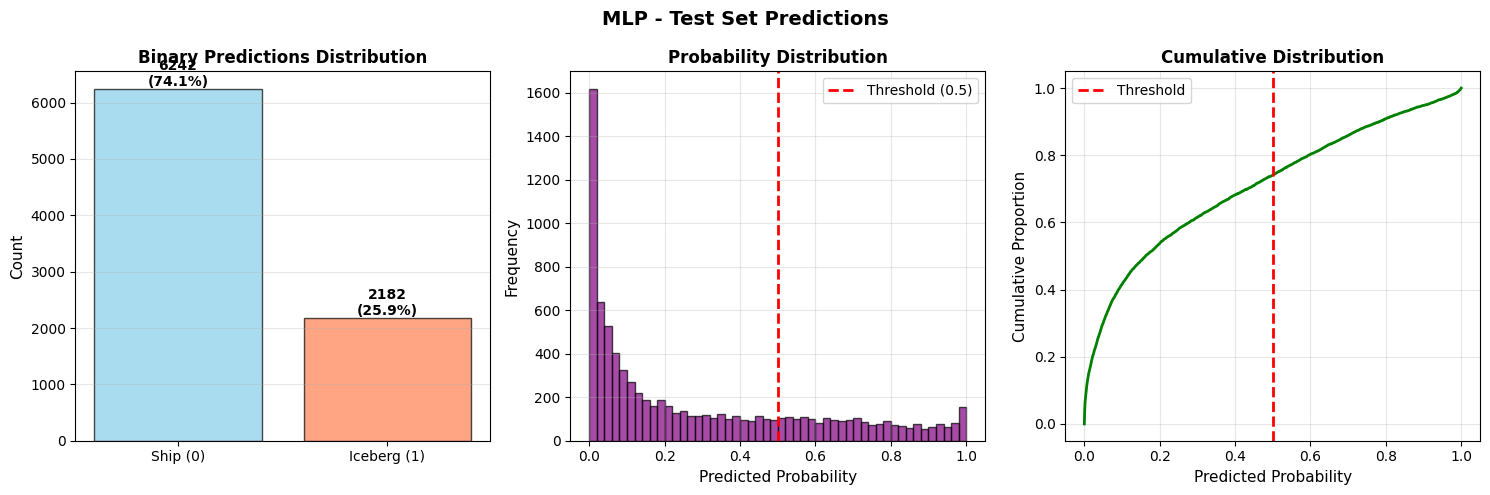


PREDICTION CONFIDENCE ANALYSIS

Confidence Breakdown:
  Very Confident Iceberg (>0.8):   764 (  9.1%)
  Confident Iceberg (0.6-0.8):     892 ( 10.6%)
  Uncertain (0.4-0.6):             1021 ( 12.1%)
  Confident Ship (0.2-0.4):        1216 ( 14.4%)
  Very Confident Ship (<0.2):      4531 ( 53.8%)

Average Model Confidence: 0.8318
  (How certain the model is on average)

TEST EVALUATION COMPLETE!

Outputs saved to: outputs/milestone3_test_evaluation
  - submission.csv (for Kaggle)
  - test_predictions_distribution.png
  - test_results.pkl

📊 Predictions generated for 8424 test samples
  Submit to Kaggle to get actual performance metrics!


In [ ]:
"""
Milestone 3: Test Set Evaluation
Evaluate the best embedding classifier on the test set and generate predictions.
Even without test labels, we can generate predictions for submission.
"""

import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import warnings
warnings.filterwarnings('ignore')


def load_best_model(model_path='outputs/milestone3_fast/best_model_random_forest.pkl'):
    """Load the best model from Milestone 3."""
    print(f"Loading best model from: {model_path}")

    with open(model_path, 'rb') as f:
        saved_data = pickle.load(f)

    model = saved_data['model']
    scaler = saved_data['scaler']
    model_name = saved_data['name']

    print(f"✅ Loaded: {model_name}")
    return model, scaler, model_name


def load_test_data(test_embeddings_path, test_labels_path=None, test_ids_path=None):
    """Load test embeddings and optionally labels."""
    print("\nLoading test data...")

    with open(test_embeddings_path, 'rb') as f:
        test_embeddings = np.array(pickle.load(f))

    print(f"✅ Test embeddings: {test_embeddings.shape}")

    # Try to load test labels if available
    test_labels = None
    if test_labels_path:
        try:
            with open(test_labels_path, 'rb') as f:
                test_labels = np.array(pickle.load(f))
            print(f"✅ Test labels: {test_labels.shape}")
        except:
            print("⚠️  Test labels not found")

    # Try to load test IDs for submission
    test_ids = None
    if test_ids_path:
        try:
            with open(test_ids_path, 'rb') as f:
                test_ids = pickle.load(f)
            print(f"✅ Test IDs: {len(test_ids)}")
        except:
            print("⚠️  Test IDs not found, will use indices")
            test_ids = np.arange(len(test_embeddings))
    else:
        test_ids = np.arange(len(test_embeddings))

    return test_embeddings, test_labels, test_ids


def evaluate_on_test(model, scaler, test_embeddings, test_labels=None):
    """Evaluate model on test set."""
    print("\n" + "="*70)
    print("EVALUATING ON TEST SET")
    print("="*70)

    # Scale test embeddings
    X_test_scaled = scaler.transform(test_embeddings)

    # Generate predictions
    print("\nGenerating predictions...")
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1]

    print(f"✅ Generated {len(y_pred)} predictions")

    # Prediction statistics
    print(f"\nPrediction Distribution:")
    print(f"  Predicted Ships (0):    {np.sum(y_pred == 0)} ({np.mean(y_pred == 0)*100:.1f}%)")
    print(f"  Predicted Icebergs (1): {np.sum(y_pred == 1)} ({np.mean(y_pred == 1)*100:.1f}%)")

    print(f"\nProbability Statistics:")
    print(f"  Mean probability: {y_proba.mean():.4f}")
    print(f"  Std probability:  {y_proba.std():.4f}")
    print(f"  Min probability:  {y_proba.min():.4f}")
    print(f"  Max probability:  {y_proba.max():.4f}")

    # If we have test labels, calculate metrics
    results = {
        'predictions': y_pred,
        'probabilities': y_proba
    }

    if test_labels is not None:
        print("\n" + "="*70)
        print("TEST SET PERFORMANCE METRICS")
        print("="*70)

        accuracy = accuracy_score(test_labels, y_pred)
        precision = precision_score(test_labels, y_pred)
        recall = recall_score(test_labels, y_pred)
        f1 = f1_score(test_labels, y_pred)

        print(f"\n  Accuracy:  {accuracy:.4f}")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall:    {recall:.4f}")
        print(f"  F1 Score:  {f1:.4f}")

        results['accuracy'] = accuracy
        results['precision'] = precision
        results['recall'] = recall
        results['f1'] = f1

        print("\n📋 COPY THESE VALUES FOR YOUR REPORT:")
        print("="*70)
        print(f"Test Set Results ({model.__class__.__name__}):")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall:    {recall:.4f}")
        print(f"  F1 Score:  {f1:.4f}")
        print(f"  Accuracy:  {accuracy:.4f}")
        print("="*70)
    else:
        print("\n⚠️  No test labels available - cannot calculate precision/recall")
        print("   Predictions will be saved for Kaggle submission")

    return results


def create_submission_file(test_ids, predictions, probabilities,
                           filename='milestone3_submission.csv'):
    """Create Kaggle submission file."""
    print(f"\n{'='*70}")
    print("CREATING SUBMISSION FILE")
    print(f"{'='*70}")

    submission = pd.DataFrame({
        'id': test_ids,
        'is_iceberg': probabilities  # Kaggle wants probabilities, not binary predictions
    })

    submission.to_csv(filename, index=False)
    print(f"✅ Saved: {filename}")
    print(f"   Format: id, is_iceberg (probability)")
    print(f"   Ready for Kaggle submission!")

    return submission


def plot_prediction_distribution(predictions, probabilities, model_name, save_path=None):
    """Plot distribution of predictions."""
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Plot 1: Binary predictions
    classes, counts = np.unique(predictions, return_counts=True)
    colors = ['skyblue', 'coral']
    axes[0].bar(['Ship (0)', 'Iceberg (1)'], counts, color=colors, alpha=0.7, edgecolor='black')
    axes[0].set_ylabel('Count', fontsize=11)
    axes[0].set_title('Binary Predictions Distribution', fontsize=12, fontweight='bold')
    axes[0].grid(True, alpha=0.3, axis='y')

    # Add percentages
    for i, (cls, cnt) in enumerate(zip(['Ship', 'Iceberg'], counts)):
        pct = (cnt / len(predictions)) * 100
        axes[0].text(i, cnt, f'{cnt}\n({pct:.1f}%)',
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

    # Plot 2: Probability histogram
    axes[1].hist(probabilities, bins=50, edgecolor='black', alpha=0.7, color='purple')
    axes[1].axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Threshold (0.5)')
    axes[1].set_xlabel('Predicted Probability', fontsize=11)
    axes[1].set_ylabel('Frequency', fontsize=11)
    axes[1].set_title('Probability Distribution', fontsize=12, fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    # Plot 3: Cumulative distribution
    sorted_probs = np.sort(probabilities)
    cumulative = np.arange(1, len(sorted_probs) + 1) / len(sorted_probs)
    axes[2].plot(sorted_probs, cumulative, linewidth=2, color='green')
    axes[2].axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Threshold')
    axes[2].set_xlabel('Predicted Probability', fontsize=11)
    axes[2].set_ylabel('Cumulative Proportion', fontsize=11)
    axes[2].set_title('Cumulative Distribution', fontsize=12, fontweight='bold')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)

    plt.suptitle(f'{model_name} - Test Set Predictions', fontsize=14, fontweight='bold')
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✅ Saved: {save_path}")
    plt.show()


def analyze_confidence(predictions, probabilities):
    """Analyze prediction confidence."""
    print(f"\n{'='*70}")
    print("PREDICTION CONFIDENCE ANALYSIS")
    print(f"{'='*70}")

    # Categorize by confidence
    very_confident_iceberg = np.sum(probabilities > 0.8)
    confident_iceberg = np.sum((probabilities > 0.6) & (probabilities <= 0.8))
    uncertain = np.sum((probabilities >= 0.4) & (probabilities <= 0.6))
    confident_ship = np.sum((probabilities >= 0.2) & (probabilities < 0.4))
    very_confident_ship = np.sum(probabilities < 0.2)

    total = len(probabilities)

    print(f"\nConfidence Breakdown:")
    print(f"  Very Confident Iceberg (>0.8):  {very_confident_iceberg:4d} ({very_confident_iceberg/total*100:5.1f}%)")
    print(f"  Confident Iceberg (0.6-0.8):    {confident_iceberg:4d} ({confident_iceberg/total*100:5.1f}%)")
    print(f"  Uncertain (0.4-0.6):             {uncertain:4d} ({uncertain/total*100:5.1f}%)")
    print(f"  Confident Ship (0.2-0.4):        {confident_ship:4d} ({confident_ship/total*100:5.1f}%)")
    print(f"  Very Confident Ship (<0.2):      {very_confident_ship:4d} ({very_confident_ship/total*100:5.1f}%)")

    # Model confidence
    avg_confidence = np.mean(np.maximum(probabilities, 1 - probabilities))
    print(f"\nAverage Model Confidence: {avg_confidence:.4f}")
    print(f"  (How certain the model is on average)")


def main():
    """Main execution for test set evaluation."""
    # =================================================================
    # CONFIGURATION - UPDATE THESE PATHS
    # =================================================================

    # Path to best model from Milestone 3
    BEST_MODEL_PATH = '/content/outputs/milestone3_fast/best_model_mlp.pkl'
    # ^ Update this to match your best model file name

    # Test data paths
    TEST_EMBEDDINGS_PATH = '/content/vit_test_embeddings.pkl'
    TEST_LABELS_PATH = None  # Path if you have test labels, else None
    TEST_IDS_PATH = None     # Path to test IDs for submission, else None

    OUTPUT_DIR = 'outputs/milestone3_test_evaluation'

    # =================================================================

    import os
    os.makedirs(OUTPUT_DIR, exist_ok=True)

    print("\n" + "="*70)
    print("MILESTONE 3: TEST SET EVALUATION")
    print("="*70)

    # Load best model
    model, scaler, model_name = load_best_model(BEST_MODEL_PATH)

    # Load test data
    test_embeddings, test_labels, test_ids = load_test_data(
        TEST_EMBEDDINGS_PATH, TEST_LABELS_PATH, TEST_IDS_PATH
    )

    # Evaluate on test set
    results = evaluate_on_test(model, scaler, test_embeddings, test_labels)

    # Create submission file
    submission = create_submission_file(
        test_ids,
        results['predictions'],
        results['probabilities'],
        filename=f'{OUTPUT_DIR}/submission.csv'
    )

    # Visualizations
    print("\nGenerating visualizations...")
    plot_prediction_distribution(
        results['predictions'],
        results['probabilities'],
        model_name,
        save_path=f'{OUTPUT_DIR}/test_predictions_distribution.png'
    )

    # Confidence analysis
    analyze_confidence(results['predictions'], results['probabilities'])

    # Save results
    results_to_save = {
        'model_name': model_name,
        'predictions': results['predictions'],
        'probabilities': results['probabilities'],
        'test_ids': test_ids
    }

    if test_labels is not None:
        results_to_save['metrics'] = {
            'accuracy': results['accuracy'],
            'precision': results['precision'],
            'recall': results['recall'],
            'f1': results['f1']
        }

    with open(f'{OUTPUT_DIR}/test_results.pkl', 'wb') as f:
        pickle.dump(results_to_save, f)

    print(f"\n{'='*70}")
    print("TEST EVALUATION COMPLETE!")
    print(f"{'='*70}")
    print(f"\nOutputs saved to: {OUTPUT_DIR}")
    print(f"  - submission.csv (for Kaggle)")
    print(f"  - test_predictions_distribution.png")
    print(f"  - test_results.pkl")

    if test_labels is not None:
        print(f"\n🎯 Final Test Set Performance:")
        print(f"  Model: {model_name}")
        print(f"  Precision: {results['precision']:.4f}")
        print(f"  Recall:    {results['recall']:.4f}")
        print(f"  F1 Score:  {results['f1']:.4f}")
    else:
        print(f"\n📊 Predictions generated for {len(results['predictions'])} test samples")
        print(f"  Submit to Kaggle to get actual performance metrics!")

    print("="*70)


if __name__ == "__main__":
    main()


MILESTONE 3: BASELINE COMPARISON ANALYSIS (AUTO-LOAD)
Loading Milestone 3 results from: /content/outputs/milestone3_fast/all_results.pkl
✅ Loaded results for 6 models
   Best model: MLP

BASELINE vs EMBEDDING-BASED CLASSIFIER COMPARISON

PERFORMANCE COMPARISON (VALIDATION SETS)

Model                          Precision    Recall       F1 Score     Accuracy    
----------------------------------------------------------------------
Baseline CNN                   0.9329       0.6986       0.7990       0.8402      
Embedding (Logistic Regression) 0.6986       0.6711       0.6846       0.7081      
Embedding (SVM)                0.7027       0.6842       0.6933       0.7143      
Embedding (Random Forest)      0.7284       0.7763       0.7516       0.7578      
Embedding (Gradient Boosting)  0.7067       0.6974       0.7020       0.7205      
Embedding (MLP)                0.7229       0.7895       0.7547       0.7578      
Embedding (XGBoost)            0.7368       0.7368       0.7368   

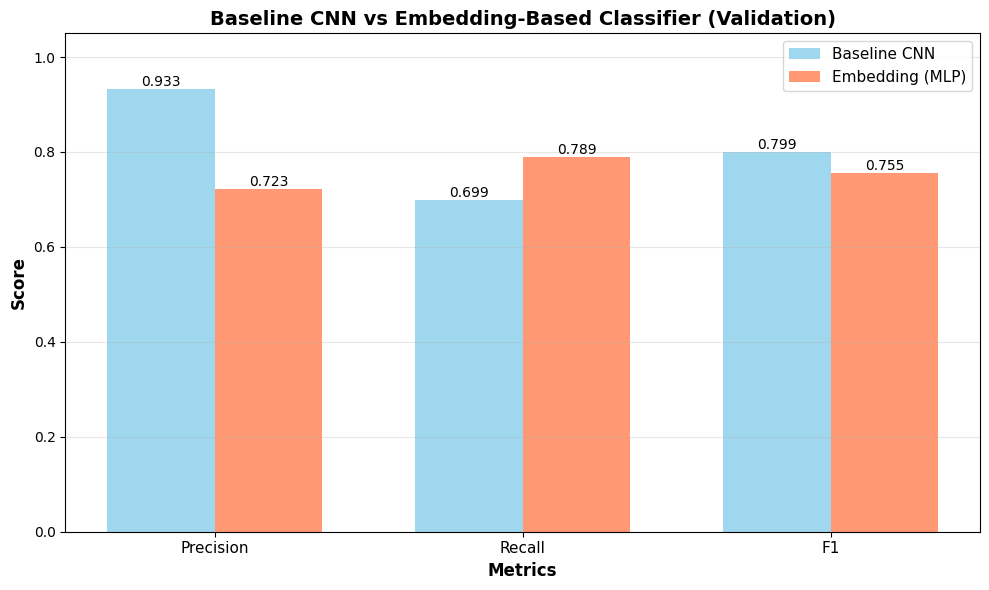

Saved: outputs/milestone3_comparison/all_models_comparison.png


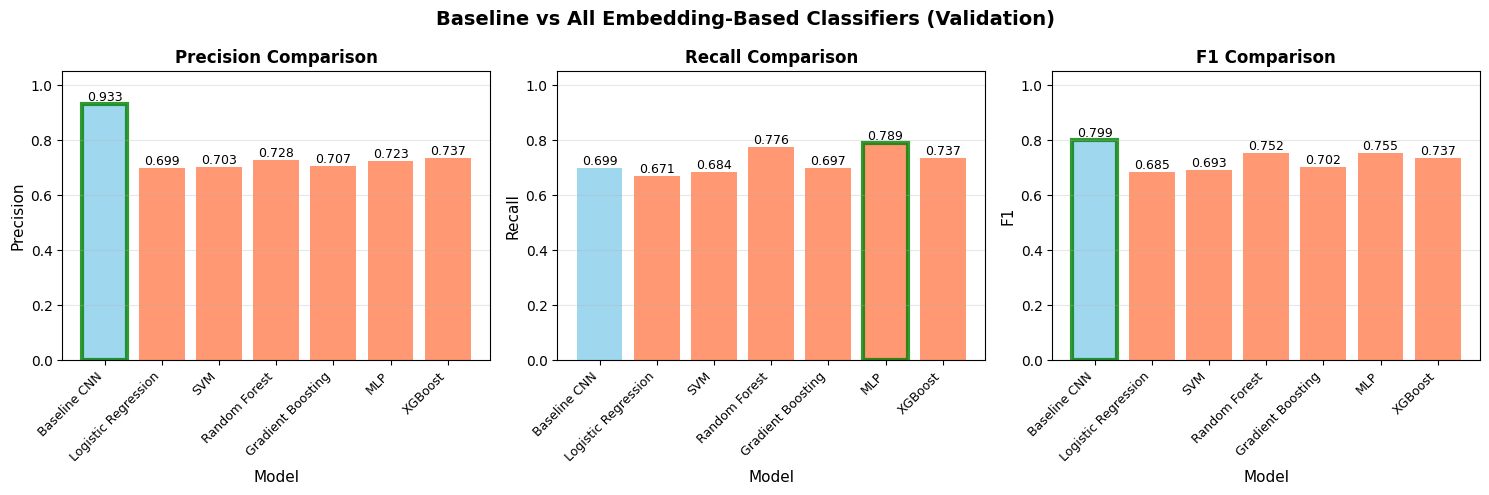


MILESTONE 3: BASELINE COMPARISON REPORT

Baseline Model (Milestone 1 CNN - Validation Set):
  Precision: 0.9329
  Recall:    0.6986
  F1 Score:  0.7990
  Accuracy:  0.8402

Embedding-Based Classifiers (Validation Set):
----------------------------------------------------------------------

Logistic Regression:
  Precision: 0.6986
  Recall:    0.6711
  F1 Score:  0.6846
  Accuracy:  0.7081

  Improvement over baseline:
    Precision: -25.11%
    Recall:    -3.94%
    F1 Score:  -14.32%

SVM:
  Precision: 0.7027
  Recall:    0.6842
  F1 Score:  0.6933
  Accuracy:  0.7143

  Improvement over baseline:
    Precision: -24.68%
    Recall:    -2.06%
    F1 Score:  -13.22%

Random Forest:
  Precision: 0.7284
  Recall:    0.7763
  F1 Score:  0.7516
  Accuracy:  0.7578

  Improvement over baseline:
    Precision: -21.92%
    Recall:    +11.12%
    F1 Score:  -5.93%

Gradient Boosting:
  Precision: 0.7067
  Recall:    0.6974
  F1 Score:  0.7020
  Accuracy:  0.7205

  Improvement over baseline:
 

In [ ]:
"""
Milestone 3 - Baseline Comparison (AUTO-LOAD VERSION)
Automatically loads Milestone 3 results from saved files and compares with baseline.
"""

import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import warnings
import os
warnings.filterwarnings('ignore')


def load_milestone3_results(results_path='/content/outputs/milestone3_fast/all_results.pkl'):
    """Automatically load Milestone 3 results from saved pickle file."""
    print(f"Loading Milestone 3 results from: {results_path}")

    if not os.path.exists(results_path):
        print(f"❌ File not found: {results_path}")
        print("\nPlease check:")
        print("  1. Did you run milestone3_classifier_FAST.py?")
        print("  2. Is the path correct?")
        print("  3. Look for the file: outputs/milestone3_fast/all_results.pkl")
        return None

    with open(results_path, 'rb') as f:
        all_results = pickle.load(f)

    print(f"✅ Loaded results for {len(all_results['results'])} models")
    print(f"   Best model: {all_results['best_model_name']}")

    return all_results['results']


class BaselineComparison:
    """Compare embedding-based models with baseline CNN."""

    def __init__(self, baseline_results, embedding_results, test_labels=None):
        """Initialize comparison analyzer."""
        self.baseline = baseline_results
        self.embedding = embedding_results
        self.test_labels = test_labels

        print("\n" + "="*70)
        print("BASELINE vs EMBEDDING-BASED CLASSIFIER COMPARISON")
        print("="*70)

    def create_comparison_table(self):
        """Create detailed comparison table."""
        print("\n" + "="*70)
        print("PERFORMANCE COMPARISON (VALIDATION SETS)")
        print("="*70)
        print(f"\n{'Model':<30} {'Precision':<12} {'Recall':<12} {'F1 Score':<12} {'Accuracy':<12}")
        print("-" * 70)

        # Baseline
        print(f"{'Baseline CNN':<30} ", end='')
        print(f"{self.baseline['precision']:<12.4f} {self.baseline['recall']:<12.4f} ", end='')
        print(f"{self.baseline['f1']:<12.4f} {self.baseline.get('accuracy', 0):<12.4f}")

        # Each embedding model (use validation metrics)
        for model_name, results in self.embedding.items():
            val_res = results['val']
            print(f"{f'Embedding ({model_name})':<30} ", end='')
            print(f"{val_res['precision']:<12.4f} {val_res['recall']:<12.4f} ", end='')
            print(f"{val_res['f1']:<12.4f} {val_res['accuracy']:<12.4f}")

        print("\n" + "="*70)

        # Calculate improvements
        print("\nIMPROVEMENT OVER BASELINE:")
        print("-" * 70)

        for model_name, results in self.embedding.items():
            val_res = results['val']

            prec_improv = ((val_res['precision'] - self.baseline['precision']) /
                          self.baseline['precision'] * 100)
            rec_improv = ((val_res['recall'] - self.baseline['recall']) /
                         self.baseline['recall'] * 100)
            f1_improv = ((val_res['f1'] - self.baseline['f1']) /
                        self.baseline['f1'] * 100)

            print(f"\n{model_name}:")
            print(f"  Precision: {prec_improv:+.2f}%")
            print(f"  Recall:    {rec_improv:+.2f}%")
            print(f"  F1 Score:  {f1_improv:+.2f}%")

    def plot_metric_comparison(self, save_path=None):
        """Plot bar chart comparing all metrics."""
        metrics = ['precision', 'recall', 'f1']

        # Prepare data
        baseline_vals = [self.baseline[m] for m in metrics]

        # Get best embedding model
        best_model_name = max(self.embedding.keys(),
                            key=lambda x: self.embedding[x]['val']['f1'])
        embedding_vals = [self.embedding[best_model_name]['val'][m]
                         for m in metrics]

        x = np.arange(len(metrics))
        width = 0.35

        fig, ax = plt.subplots(figsize=(10, 6))

        bars1 = ax.bar(x - width/2, baseline_vals, width,
                      label='Baseline CNN', alpha=0.8, color='skyblue')
        bars2 = ax.bar(x + width/2, embedding_vals, width,
                      label=f'Embedding ({best_model_name})', alpha=0.8, color='coral')

        # Add value labels on bars
        for bars in [bars1, bars2]:
            for bar in bars:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height,
                       f'{height:.3f}',
                       ha='center', va='bottom', fontsize=10)

        ax.set_xlabel('Metrics', fontsize=12, fontweight='bold')
        ax.set_ylabel('Score', fontsize=12, fontweight='bold')
        ax.set_title('Baseline CNN vs Embedding-Based Classifier (Validation)',
                    fontsize=14, fontweight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels([m.capitalize() for m in metrics], fontsize=11)
        ax.legend(fontsize=11)
        ax.grid(True, alpha=0.3, axis='y')
        ax.set_ylim([0, 1.05])

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Saved: {save_path}")
        plt.show()

    def plot_all_models_comparison(self, save_path=None):
        """Plot comparison including all embedding models."""
        metrics = ['precision', 'recall', 'f1']

        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        for idx, metric in enumerate(metrics):
            models = ['Baseline CNN'] + list(self.embedding.keys())
            values = [self.baseline[metric]]

            for model_name in self.embedding.keys():
                values.append(self.embedding[model_name]['val'][metric])

            colors = ['skyblue'] + ['coral'] * (len(models) - 1)
            bars = axes[idx].bar(range(len(models)), values, color=colors, alpha=0.8)

            # Highlight best model
            best_idx = values.index(max(values))
            bars[best_idx].set_edgecolor('green')
            bars[best_idx].set_linewidth(3)

            axes[idx].set_xlabel('Model', fontsize=11)
            axes[idx].set_ylabel(metric.capitalize(), fontsize=11)
            axes[idx].set_title(f'{metric.capitalize()} Comparison',
                              fontsize=12, fontweight='bold')
            axes[idx].set_xticks(range(len(models)))
            axes[idx].set_xticklabels(models, rotation=45, ha='right', fontsize=9)
            axes[idx].grid(True, alpha=0.3, axis='y')
            axes[idx].set_ylim([0, 1.05])

            # Add value labels
            for i, (bar, val) in enumerate(zip(bars, values)):
                axes[idx].text(bar.get_x() + bar.get_width()/2., val,
                             f'{val:.3f}',
                             ha='center', va='bottom', fontsize=9)

        plt.suptitle('Baseline vs All Embedding-Based Classifiers (Validation)',
                    fontsize=14, fontweight='bold')
        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Saved: {save_path}")
        plt.show()

    def generate_comparison_report(self, save_path=None):
        """Generate comprehensive comparison report."""
        report = f"\n{'='*70}\n"
        report += "MILESTONE 3: BASELINE COMPARISON REPORT\n"
        report += f"{'='*70}\n\n"

        report += "Baseline Model (Milestone 1 CNN - Validation Set):\n"
        report += f"  Precision: {self.baseline['precision']:.4f}\n"
        report += f"  Recall:    {self.baseline['recall']:.4f}\n"
        report += f"  F1 Score:  {self.baseline['f1']:.4f}\n"
        if 'accuracy' in self.baseline:
            report += f"  Accuracy:  {self.baseline['accuracy']:.4f}\n"
        report += "\n"

        report += "Embedding-Based Classifiers (Validation Set):\n"
        report += "-" * 70 + "\n"

        best_f1 = 0
        best_model = None

        for model_name, results in self.embedding.items():
            val_res = results['val']
            report += f"\n{model_name}:\n"
            report += f"  Precision: {val_res['precision']:.4f}\n"
            report += f"  Recall:    {val_res['recall']:.4f}\n"
            report += f"  F1 Score:  {val_res['f1']:.4f}\n"
            report += f"  Accuracy:  {val_res['accuracy']:.4f}\n"

            # Calculate improvement
            prec_improv = ((val_res['precision'] - self.baseline['precision']) /
                          self.baseline['precision'] * 100)
            rec_improv = ((val_res['recall'] - self.baseline['recall']) /
                         self.baseline['recall'] * 100)
            f1_improv = ((val_res['f1'] - self.baseline['f1']) /
                        self.baseline['f1'] * 100)

            report += f"\n  Improvement over baseline:\n"
            report += f"    Precision: {prec_improv:+.2f}%\n"
            report += f"    Recall:    {rec_improv:+.2f}%\n"
            report += f"    F1 Score:  {f1_improv:+.2f}%\n"

            if val_res['f1'] > best_f1:
                best_f1 = val_res['f1']
                best_model = model_name

        report += f"\n{'='*70}\n"
        report += "OVERALL ASSESSMENT:\n"
        report += f"{'='*70}\n"
        report += f"Best Embedding Model: {best_model}\n"
        report += f"Best F1 Score: {best_f1:.4f}\n"
        report += f"Baseline F1 Score: {self.baseline['f1']:.4f}\n"

        f1_improvement = ((best_f1 - self.baseline['f1']) / self.baseline['f1'] * 100)

        if f1_improvement > 5:
            report += f"\n✅ SIGNIFICANT IMPROVEMENT: +{f1_improvement:.2f}%\n"
            report += "The embedding-based approach substantially outperforms the baseline.\n"
            report += f"Recommendation: Use {best_model} for deployment.\n"
        elif f1_improvement > 0:
            report += f"\n✅ MODERATE IMPROVEMENT: +{f1_improvement:.2f}%\n"
            report += "The embedding-based approach shows improvement over baseline.\n"
            report += f"Recommendation: Consider {best_model} for deployment.\n"
        elif f1_improvement > -5:
            report += f"\n⚠️ COMPARABLE PERFORMANCE: {f1_improvement:+.2f}%\n"
            report += "Both approaches perform similarly.\n"
            report += "Recommendation: Baseline may be sufficient, but embedding approach\n"
            report += "                offers benefits in transfer learning scenarios.\n"
        else:
            report += f"\n❌ UNDERPERFORMANCE: {f1_improvement:+.2f}%\n"
            report += "Baseline model outperforms embedding-based approach.\n"
            report += "Recommendation: Stick with baseline model or consider fine-tuning\n"
            report += "                pre-trained models on SAR data.\n"

        report += f"{'='*70}\n"
        report += "\nNote: Both baseline and embedding models evaluated on validation sets\n"
        report += "      for fair comparison (same 90/10 or 70/30 split).\n"
        report += f"{'='*70}\n"

        print(report)

        if save_path:
            with open(save_path, 'w') as f:
                f.write(report)
            print(f"Report saved to: {save_path}")

        return report


def main():
    """Main execution for baseline comparison."""
    # =================================================================
    # CONFIGURATION - UPDATE BASELINE VALUES
    # =================================================================

    # Baseline CNN results from Milestone 1 (VALIDATION metrics)
    BASELINE_RESULTS = {
        'precision': 0.9329,  # From your baseline validation
        'recall': 0.6986,     # From your baseline validation
        'f1': 0.7990,         # From your baseline validation
        'accuracy': 0.8402    # From your baseline validation
    }

    # Path to Milestone 3 saved results
    MILESTONE3_RESULTS_PATH = '/content/outputs/milestone3_fast/all_results.pkl'

    OUTPUT_DIR = 'outputs/milestone3_comparison'

    # =================================================================

    os.makedirs(OUTPUT_DIR, exist_ok=True)

    print("\n" + "="*70)
    print("MILESTONE 3: BASELINE COMPARISON ANALYSIS (AUTO-LOAD)")
    print("="*70)

    # Load Milestone 3 results automatically
    embedding_results = load_milestone3_results(MILESTONE3_RESULTS_PATH)

    if embedding_results is None:
        print("\n❌ Could not load Milestone 3 results. Exiting.")
        return

    # Initialize comparison
    comparison = BaselineComparison(BASELINE_RESULTS, embedding_results)

    # Create comparison visualizations
    comparison.create_comparison_table()
    comparison.plot_metric_comparison(
        save_path=f'{OUTPUT_DIR}/baseline_comparison.png'
    )
    comparison.plot_all_models_comparison(
        save_path=f'{OUTPUT_DIR}/all_models_comparison.png'
    )

    # Generate report
    comparison.generate_comparison_report(
        save_path=f'{OUTPUT_DIR}/comparison_report.txt'
    )

    print("\n" + "="*70)
    print("COMPARISON ANALYSIS COMPLETE!")
    print(f"All outputs saved to: {OUTPUT_DIR}")
    print("="*70)


if __name__ == "__main__":
    main()